In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, wilcoxon ,spearmanr, pearsonr, kruskal, zscore, ttest_ind
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

from itertools import combinations


from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm

import gseapy as gp

import os
os.chdir('/lustre/scratch/kiviaho/hillock_club_senescence/')


# Download gene sets and keep those needed
gene_set_df = pd.read_excel('/lustre/scratch/kiviaho/club_scrnaseq/custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

def load_from_pickle(filename):
    import pickle
    with open(filename, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('/lustre/scratch/kiviaho/prostate_spatial/data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

def remove_overlaps(data):
    # Convert lists to sets for easier comparison
    sets = {k: set(v) for k, v in data.items()}
    
    # Iterate over each pair of lists
    for key1, set1 in sets.items():
        for key2, set2 in sets.items():
            if key1 != key2:
                # Find the intersection
                intersection = set1 & set2
                if intersection:
                    # Remove intersection from the longer list
                    if len(set1) > len(set2):
                        sets[key1] -= intersection
                    else:
                        sets[key2] -= intersection
    
    # Convert sets back to lists
    return {k: list(v) for k, v in sets.items()}

# Load gene modules
gene_modules = pd.read_excel('./gene_modules.xlsx')

gene_modules = pd.read_excel('./gene_modules.xlsx')
gene_modules_dict = gene_modules.drop(columns=['RANK']).to_dict('list')
for k in gene_modules_dict:
    gene_modules_dict[k] = [g for g in gene_modules_dict[k] if str(g) != 'nan']
print(gene_modules_dict.keys())

# Function definitions

def extract_gene_mapping(gtf_file, mapping_type='ENSG'):
    gene_mapping = {}

    with open(gtf_file, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            columns = line.strip().split('\t')
            if columns[2] == 'gene':
                attributes = columns[8].split('; ')
                gene_id = None
                gene_name = None
                for attribute in attributes:
                    if mapping_type == 'ENSG' and attribute.startswith('gene_id'):
                        gene_id = attribute.split(' ')[1].strip('"')
                    elif mapping_type == 'NCBI' and attribute.startswith('gene_id'):
                        gene_id = attribute.split(' ')[1].strip('"')
                    elif attribute.startswith('gene_name'):
                        gene_name = attribute.split(' ')[1].strip('"')
                if gene_id and gene_name:
                    gene_mapping[gene_id] = gene_name

    return pd.DataFrame(list(gene_mapping.items()), columns=['gene_id', 'gene_name'])

# Example usage:
# df = extract_gene_mapping('your_gtf_file.gtf', mapping_type='NCBI')

def extract_gene_lengths_from_gtf(file_path):
    gene_lengths = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            data = line.strip().split('\t')
            if data[2] == 'gene':
                attributes = data[8].split(';')
                gene_name = [x.split('"')[1] for x in attributes if 'gene_name' in x][0]
                start = int(data[3])
                end = int(data[4])
                length = end - start + 1
                gene_lengths[gene_name] = length

    return gene_lengths


# Function to calculate TPM
def calculate_tpm(df,gene_lengths_per_kb):

    # Gene reads per kilobase
    df_rpk = df.divide(gene_lengths_per_kb,axis=0)

    # Total rpk per sample 
    sample_scaling_factor = df_rpk.sum()/1e6

    # TPM
    tpm_df = df_rpk.divide(sample_scaling_factor)

    return tpm_df

def remove_overlaps(data):
    # Convert lists to sets for easier comparison
    sets = {k: set(v) for k, v in data.items()}
    
    # Iterate over each pair of lists
    for key1, set1 in sets.items():
        for key2, set2 in sets.items():
            if key1 != key2:
                # Find the intersection
                intersection = set1 & set2
                if intersection:
                    # Remove intersection from the longer list
                    if len(set1) > len(set2):
                        sets[key1] -= intersection
                    else:
                        sets[key2] -= intersection
    
    # Convert sets back to lists
    return {k: list(v) for k, v in sets.items()}


def regress_out_signature(df, signature):
    # Extract the signature column
    signature_scores = df[signature]
    
    # Regress out the signature from each column
    for col in df.columns:
        if col != signature:
            X = sm.add_constant(signature_scores)
            y = df[col]
            model = sm.OLS(y, X).fit()
            df[col] = model.resid

    df = df.drop(columns=signature)
    
    return df

def regress_out_signatures(df, signatures):
    # Create the design matrix with a constant and all signature columns
    X = sm.add_constant(df[signatures])
    
    # Regress out the signatures from each column
    for col in df.columns:
        if col not in signatures:
            y = df[col]
            model = sm.OLS(y, X).fit()
            df[col] = model.resid
    
    # Remove the signature columns from the DataFrame
    df = df.drop(columns=signatures)
    
    return df


plot_save_path = '/lustre/scratch/kiviaho/hillock_club_senescence/plots/'




Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8ppxmp7n because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


dict_keys(['PrLuPa_sig', 'HALLMARK_ANDROGEN_RESPONSE', 'Luminal Henry et al. 2018', 'AR signaling', 'ELF3 upregulated Longoni et al. 2013', 'PDAC T1RS Caronni et al. 2023', 'PDAC IL1B+ Macrophages', 'PDAC scRNAseq Neutrophils', 'Prostate IL1A_B+ MDSCs', 'Prostate IL1A_B+ MDSCs (aggr.)', 'JAK_STAT_FGFR', 'Lung KACs Han et al. 2024', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'scNMF senescent epithelium', 'scNMF Club interferon', 'scNMF Club', 'Club Henry et al. 2018', 'Hillock Henry et al. 2018', 'Mouse Hillock Montoro et al. 2018', 'Mouse Hillock Luminal Lin et al. 2023', 'Immune region', 'Endothelium region', 'Fibroblast region', 'Muscle region', 'Club region', 'CRPC-AR', 'CRPC-WNT', 'CRPC-NE', 'CRPC-SCL', 'MDSC Hirz 2023', 'MDSC Calcinotto 2018', 'PMN-MDSC activity', 'Regulators_extracellular_cGAMP', 'STING_non_canonical_DNA_DAMAGE', 'TNF_NFKB_signaling_pathway', 'CHD1_signaling_i

## 5 dataset composite

In [ ]:

# Extract the gene_id to gene_name mapping table from the GTF file
gtf_file = '/lustre/scratch/kiviaho/refdata-gex-GRCh38-2020-A/genes/genes.gtf'

# Extract gene lengths from the GTF file
gene_lengths_mapping_dict = extract_gene_lengths_from_gtf(gtf_file)


### PELICAN Bova cohort

In [ ]:

# Create a gene id-gene symbol table
gene_mapping_df = extract_gene_mapping(gtf_file)
gene_mapping_dict = gene_mapping_df.set_index('gene_id').to_dict()['gene_name']
print(gene_mapping_df.head())

# Data downloads

dat = pd.read_csv('../hillock_club_senescence/data/pelican/PELICAN45_rna_featureCounts.txt',sep = '\t',index_col=0,skiprows=1)
dat = dat.drop(columns=['Chr','Start','End','Strand','Length']) # Drop unused
dat.columns = [s.replace('Aligned.sortedByCoord.out.bam','') for s in dat.columns] # Shorten sample names

dat.index = [r.split('.')[0] for r in dat.index] # strip gene version from index

# Replace the index with gene symbols
dat.index = dat.index.map(gene_mapping_dict)
dat = dat[~(dat.index.isna())]
dat = dat[~(dat.sum(axis=1) == 0)]
#dat = dat[~(dat.sum(axis=1) <= dat.shape[1])]
#dat = dat[(dat != 0).sum(axis=1) >= dat.shape[1]/2] # Non-zero counts in 10% of the samples

dat = dat.reset_index().groupby('index').sum() # Summarize duplicated genes

## TPM normalization

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]

tpm_pelican = tpm.copy()

### Labrecque mCRPC cohort

In [ ]:
# Download data and format metadata
dat = pd.read_csv('./data/labrecque_2019/GSE126078_norm_counts_TPM_GRCh38.p13_NCBI.tsv',sep='\t',index_col=0) # NCBI-generated TPM matrix from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE126078

# Replace Entrez IDs with gene symbols
gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')
gene_mapping_dict = gene_annot.set_index('GeneID')['Symbol'].to_dict()
dat.index = dat.index.map(gene_mapping_dict)

meta = pd.read_csv('./data/labrecque_2019/GSE126078_series_matrix.txt',sep='\t',skiprows=51,index_col=0)
# Extract relevant columns
meta = meta.T[['!Sample_geo_accession','!Sample_characteristics_ch1','!Sample_source_name_ch1']]

# Drop unused columns
meta = pd.DataFrame(meta.iloc[:,[0,4,5,7]])
column_names = ['GEO_ID','patient','molecular_phenotype','metastatic_site']
meta.columns = column_names

# Map the sample names onto columns
geo_to_sample_dict = meta.reset_index().set_index('GEO_ID')['index'].to_dict()
dat.columns = dat.columns.map(geo_to_sample_dict)

CRPC_only = True #### Adjust accordingly
if CRPC_only:
    meta = meta[meta.index.str.contains('CRPC')]
    dat = dat[meta.index.tolist()]
    meta['molecular_phenotype'] = pd.Categorical([s.split(': ')[1] for s in meta['molecular_phenotype']],categories=['ARpos_NEneg','ARpos_NEpos','ARneg_NEpos','ARlow_NEneg','ARneg_NEneg'])

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]

tpm_labrecque = tpm.copy()


### ARNEO cohort

In [ ]:
# Using the real set of RNA-seq data

rnaseq_data = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo/tpm_rna_seq_counts.csv',index_col=0)
metadata = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo/case-metadata.txt',index_col=0,sep='\t')

rnaseq_data = rnaseq_data.drop(columns=['ensembl_gene_id','entrezgene_id']).set_index('hgnc_symbol')

missing_meta = pd.DataFrame({
    'TRT_GROUP':np.repeat('treatment-naive',len(rnaseq_data.columns.difference(metadata.index))),
    'tc': np.nan,
    'tc_method': np.nan,
    }, index = rnaseq_data.columns.difference(metadata.index)
    )

metadata = pd.concat([metadata,missing_meta])

# Create a treatment-naive vs neoadjuvant-treated divide
metadata['TRT_GROUP_SIMPLE'] = pd.Categorical(metadata['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])
# Match the ordering
rnaseq_data = rnaseq_data[metadata.index.intersection(rnaseq_data.columns)]

# Drop duplicates
tpm_arneo = rnaseq_data[~(rnaseq_data.index.duplicated())]

# Keep just the treated samples
tpm_arneo_treated = tpm_arneo.loc[:,tpm_arneo.columns.str.contains('ARN')].copy()
tpm_arneo_naive = tpm_arneo.loc[:,tpm_arneo.columns.str.contains('PWB')].copy()


### DARANA clinical trial cohort

In [ ]:
dat = pd.read_csv('./data/darana/GSE197780_DARANA_GE_table.txt',sep='\t',index_col=1,skiprows=1,header=0)
dat = dat.drop(columns=['ensembl_gene_id'])

# Un-log2 transform
dat = (2**dat).replace(1,0)

# Keep just the treated samples

tpm_darana = dat[~(dat.index.duplicated())]

tpm_darana_naive = tpm_darana[[c for c in tpm_darana.columns if 'pre' in c]].copy()
tpm_darana_treated = tpm_darana[[c for c in tpm_darana.columns if 'post' in c]].copy()

### mCRPC SU2C Abida et al. 2019

In [ ]:
dat = pd.read_csv('./data/su2c_pcf/data_mrna_seq_fpkm_polya.txt',sep='\t',index_col=0)
meta = pd.read_csv('./data/su2c_pcf/data_clinical_sample.txt',sep='\t',index_col=0,skiprows=[0,1,2,3])

fpkm_abida = dat[~(dat.index.duplicated())]

fpkm_abida_naive = fpkm_abida[fpkm_abida.columns.intersection(meta[meta['ABI_ENZA_EXPOSURE_STATUS'].isin(['Naive'])].index)]
fpkm_abida_treated = fpkm_abida[fpkm_abida.columns.intersection(meta[meta['ABI_ENZA_EXPOSURE_STATUS'].isin(['On treatment','Exposed'])].index)]


### Aggregate tpm dataframe

In [ ]:
valid_genes = tpm_labrecque.index.intersection(tpm_pelican.index.intersection(tpm_arneo.index).intersection(tpm_darana.index)).intersection(fpkm_abida.index)

sample_annotation = {
    **dict(zip(tpm_arneo.columns,np.repeat('ARNEO',tpm_arneo.shape[1]))),
    **dict(zip(tpm_darana.columns,np.repeat('DARANA',tpm_darana.shape[1]))),
    **dict(zip(tpm_labrecque.columns,np.repeat('LABRECQUE',tpm_labrecque.shape[1]))),
    **dict(zip(tpm_pelican.columns,np.repeat('PELICAN',tpm_pelican.shape[1]))),
    **dict(zip(fpkm_abida.columns,np.repeat('SU2C',fpkm_abida.shape[1])))
    }

treatment_status = {
    **dict(zip(tpm_arneo_naive.columns,np.repeat('primary naive',tpm_arneo_naive.shape[1]))),
    **dict(zip(tpm_arneo_treated.columns,np.repeat('primary treated',tpm_arneo_treated.shape[1]))),
    **dict(zip(tpm_darana_naive.columns,np.repeat('primary naive',tpm_darana_naive.shape[1]))),
    **dict(zip(tpm_darana_treated.columns,np.repeat('primary treated',tpm_darana_treated.shape[1]))),
    **dict(zip(tpm_pelican.columns,np.repeat('metastatic naive',tpm_pelican.shape[1]))),
    **dict(zip(tpm_labrecque.columns,np.repeat('metastatic treated',tpm_labrecque.shape[1]))),
    **dict(zip(fpkm_abida_naive.columns,np.repeat('metastatic naive',fpkm_abida_naive.shape[1]))),
    **dict(zip(fpkm_abida_treated.columns,np.repeat('metastatic treated',fpkm_abida_treated.shape[1])))
    }

tpm = pd.concat([tpm_arneo.loc[valid_genes],tpm_labrecque.loc[valid_genes],tpm_darana.loc[valid_genes],tpm_pelican.loc[valid_genes],fpkm_abida.loc[valid_genes]],axis=1)  # Everything
#tpm = pd.concat([tpm_arneo_treated.loc[valid_genes],tpm_labrecque.loc[valid_genes],tpm_darana_treated.loc[valid_genes],fpkm_abida_treated.loc[valid_genes]],axis=1) # Only treated
#tpm = pd.concat([tpm_arneo_treated.loc[valid_genes],tpm_darana_treated.loc[valid_genes]],axis=1) # only primary treated
#tpm = pd.concat([tpm_labrecque.loc[valid_genes],fpkm_abida_treated.loc[valid_genes]],axis=1) # Only metastatic treated
#tpm = pd.concat([tpm_arneo_naive.loc[valid_genes],tpm_darana_naive.loc[valid_genes], tpm_pelican.loc[valid_genes],fpkm_abida_naive.loc[valid_genes]],axis=1) # only treatment-naive samples

gsva_res = gp.gsva(data=tpm,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

gsva_res_df = gsva_res_df.set_index('Sample Identifier')

### Plot PCA's to get a handle on the variation

In [ ]:
## From TPM gene counts
## Glaring batch effects present 

hue_var = 'dataset' # 
pal = 'tab10'

# Perform PCA
dat = tpm.T.copy()

dat_standardized = (dat - dat.mean()) / dat.std()
dat_standardized = dat_standardized.loc[:,~(dat_standardized.isna().all())]

df = gsva_res_df.loc[dat.index]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(dat_standardized)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df.index = df.index
principal_df = pd.concat([principal_df,df[['CRPC-AR','scNMF Club','CRPC-NE','CRPC-SCL']].astype('float')],axis=1)

principal_df['dataset'] = principal_df.index.map(sample_annotation)
principal_df['treatment_status'] = principal_df.index.map(treatment_status)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scatter plot
plt.figure(figsize=(4, 3))
sns.scatterplot(principal_df, x = 'PC1', y = 'PC2', hue = hue_var, palette= pal, s = 20, edgecolor='black',linewidth = 0.6)
plt.title('2D Scatter Plot of Principal Components')
plt.xlabel(f'Principal Component 1 (PC1) - {explained_variance_ratio[0]*100:.2f}% Variance')
plt.ylabel(f'Principal Component 2 (PC2) - {explained_variance_ratio[1]*100:.2f}% Variance')
plt.grid(True)

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_data_normalized_pca.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_data_normalized_pca.pdf')
plt.show()

In [ ]:
# GSVA score
# No obvious batch effects here

hue_var = 'dataset' # 
pal = 'tab10'

# Perform PCA
dat = gsva_res_df.copy()

pca = PCA(n_components=2)
principal_components = pca.fit_transform(dat)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df.index = dat.index
principal_df = pd.concat([principal_df,df[['CRPC-AR','scNMF Club','CRPC-NE','CRPC-SCL']].astype('float')],axis=1)

principal_df['dataset'] = principal_df.index.map(sample_annotation)
principal_df['treatment_status'] = pd.Categorical(principal_df.index.map(treatment_status),categories = ['primary naive','primary treated','metastatic naive','metastatic treated'])
principal_df.loc[principal_df['treatment_status'].str.contains('primary').fillna(False),'site'] = 'primary'
principal_df.loc[principal_df['treatment_status'].str.contains('metastatic').fillna(False),'site'] = 'metastatic'
principal_df.loc[principal_df['treatment_status'].str.contains('naive').fillna(False),'treatment'] = 'naive'
principal_df.loc[principal_df['treatment_status'].str.contains('treated').fillna(False),'treatment'] = 'treated'

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scatter plot
plt.figure(figsize=(4, 3))
sns.scatterplot(principal_df, x = 'PC1', y = 'PC2', hue = hue_var, palette= pal, s = 20, edgecolor='black',linewidth = 0.6)
plt.title('2D Scatter Plot of Principal Components')
plt.xlabel(f'Principal Component 1 (PC1) - {explained_variance_ratio[0]*100:.2f}% Variance')
plt.ylabel(f'Principal Component 2 (PC2) - {explained_variance_ratio[1]*100:.2f}% Variance')
plt.grid(True)

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_GSVA_score_pca.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_{hue_var}_samples_rna_seq_GSVA_score_pca.pdf')

plt.show()

### Plot score correlation matrices

In [ ]:
sns.set_theme(style='white',font_scale=0.5)
modules = ['HALLMARK_ANDROGEN_RESPONSE','ELF3 upregulated Longoni et al. 2013','PCCAT Scissor_Synergistic_BCROS_Epi UP','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP',] # gene_modules_dict.keys()

# 'Mouse Hillock Luminal Lin et al. 2023', 'Hillock Henry et al. 2018',
#modules += ['Endothelium region', 'Fibroblast region', 'Muscle region',]
#modules += ['MDSC Hirz 2023','MDSC Calcinotto 2018','PMN-MDSC activity','STING_non_canonical_DNA_DAMAGE','CHD1_signaling_in_NF-κB_pathway',]

corr_df = gsva_res_df[modules].astype('float').corr('spearman')



# Sample DataFrame
df = gsva_res_df[modules].astype('float').copy()

# Calculate the correlation matrix and p-values
corr_df = df.corr()
p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)

for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        if i != j:
            _, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
            p_values.iloc[i, j] = p_value

# Adjust p-values using Benjamini-Hochberg method
_, padj, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
padj_matrix = padj.reshape(p_values.shape)

# Set correlations with padj >= 0.05 to NaN
corr_df[padj_matrix >= 0.05] = 0

sns.clustermap(corr_df,
               #square=True,
               figsize=(4,4),
               cmap='bwr',
               vmin=-1,
               vmax=1
               )

#plt.title('All combined')
#plt.tight_layout()
print(tpm.shape[1])

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_correlation_matrix.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_correlation_matrix.pdf')
plt.show()


In [ ]:

modules = ['scNMF Club','JAK_STAT_FGFR','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE'] # gene_modules_dict.keys()


# 'Mouse Hillock Luminal Lin et al. 2023', 'Hillock Henry et al. 2018',
#modules += ['Endothelium region', 'Fibroblast region', 'Muscle region',]
modules += ['MDSC Hirz 2023','MDSC Calcinotto 2018','PMN-MDSC activity','STING_non_canonical_DNA_DAMAGE','CHD1_signaling_in_NF-κB_pathway',]

corr_df = gsva_res_df[modules].astype('float').corr('pearson')

# Sample DataFrame
df = gsva_res_df[modules].astype('float').copy()

# Calculate the correlation matrix and p-values
corr_df = df.corr()
p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)

for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        if i != j:
            _, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
            p_values.iloc[i, j] = p_value

# Adjust p-values using Benjamini-Hochberg method
_, padj, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
padj_matrix = padj.reshape(p_values.shape)

# Set correlations with padj >= 0.05 to NaN
corr_df[padj_matrix >= 0.05] = 0

sns.clustermap(corr_df,
               #square=True,
               figsize=(4,4),
               cmap='bwr',
               vmin=-1,
               vmax=1
               )

#plt.title('All combined')
#plt.tight_layout()
print(tpm.shape[1])

plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_immune_correlation_matrix.png',dpi=120)
plt.savefig(f'./plots/aggregate_{tpm.shape[1]}_samples_rna_seq_data_immune_correlation_matrix.pdf')
plt.show()


## DARANA paired samples

In [97]:
dat = pd.read_csv('./data/darana/GSE197780_DARANA_GE_table.txt',sep='\t',index_col=1,skiprows=1,header=0)
dat = dat.drop(columns=['ensembl_gene_id'])

# Un-log2(count + 1) transform
dat = (2**dat) - 1

tpm_darana = dat[~(dat.index.duplicated())]

# Load metadata
meta = pd.DataFrame({'patient':[s.split('_')[0] for s in tpm_darana.columns], 'treatment_status' : np.nan},index = tpm_darana.columns)
meta.loc[meta.index.str.contains('pre'),'treatment_status'] = 'naive'
meta.loc[meta.index.str.contains('post'),'treatment_status'] = 'treated'
meta['treatment_status'] = pd.Categorical(meta['treatment_status'],categories = ['naive','treated'])
meta = meta.sort_index()

tpm_darana = tpm_darana[meta.index]
""" 
# Score genes
gsva_res = gp.gsva(data=tpm_darana,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

gsva_res_df = gsva_res_df.set_index('Sample Identifier').astype('float')

# Testing regressing out androgen response
#gsva_res_df = regress_out_signature(gsva_res_df, 'HALLMARK_ANDROGEN_RESPONSE') # HALLMARK_ANDROGEN_RESPONSE, AR signaling
gsva_res_df = regress_out_signatures(gsva_res_df, ['HALLMARK_ANDROGEN_RESPONSE','BPECT Luminal Identity']) # HALLMARK_ANDROGEN_RESPONSE, AR signaling

if (gsva_res_df.index == meta.index).all():
    dat = pd.concat([gsva_res_df,meta], axis=1)

 """
rnaseq_data_zscore = zscore(tpm_darana,axis=1)

# Calculate median Z-score of the set of genes
median_zscore = pd.DataFrame(columns = gene_modules_dict.keys(),index = rnaseq_data_zscore.columns)
for k in gene_modules_dict:
    sig = rnaseq_data_zscore.index.intersection(gene_modules_dict[k])
    median_zscore[k] = rnaseq_data_zscore.loc[sig].median()

# Regress out the effect of andorgen signaling
median_zscore = regress_out_signatures(median_zscore, ['HALLMARK_ANDROGEN_RESPONSE','BPECT Luminal Identity'])

if (median_zscore.index == meta.index).all():
    dat = pd.concat([median_zscore,meta], axis=1)

dat = pd.concat([dat,rnaseq_data_zscore.T],axis=1)




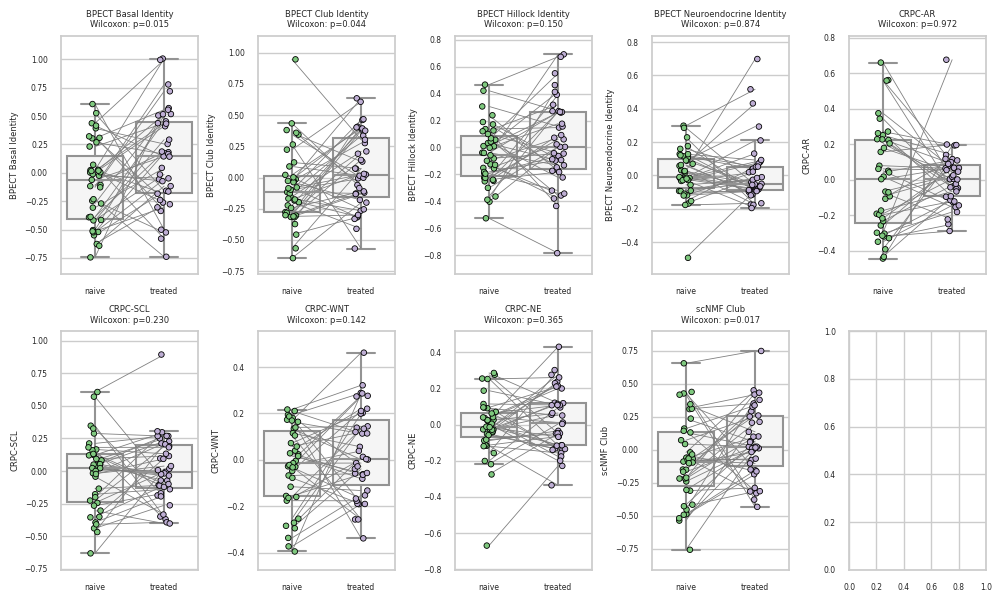

In [98]:
sns.set_theme(style='whitegrid', font_scale=0.5, palette='Accent')

# Only keep those with paired samples
plot_df = dat[dat['patient'].isin(meta['patient'].value_counts()[(meta['patient'].value_counts() == 2)].index)]

modules = [
    'BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', 'BPECT Neuroendocrine Identity',
    'CRPC-AR', 'CRPC-SCL', 'CRPC-WNT', 'CRPC-NE', 'scNMF Club'
]

# Calculate the number of columns needed
num_modules = len(modules)
num_cols = 5
num_rows = int(np.ceil(num_modules / num_cols))  # 5 columns

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*2,num_rows * 3))

for idx, signature in enumerate(modules):
    row = idx // num_cols
    col = idx % num_cols

    ax = axs[row, col]

    sns.boxplot(data=plot_df, x='treatment_status', y=signature, color='whitesmoke', fliersize=0, ax=ax)
    sns.stripplot(data=plot_df, x='treatment_status', y=signature, hue='treatment_status', s=4, edgecolor='black', linewidth=0.6, legend=False, ax=ax)

    for patient in plot_df['patient'].unique():
        patient_data = plot_df[plot_df['patient'] == patient]
        ax.plot(patient_data['treatment_status'], patient_data[signature], color='gray', linestyle='-', linewidth=0.6)

    g1 = plot_df[plot_df['treatment_status'] == 'treated'].sort_values('patient')
    g2 = plot_df[plot_df['treatment_status'] == 'naive'].sort_values('patient')

    if (pd.Index(g2['patient']) == pd.Index(g2['patient'])).all():
        stat, pval = wilcoxon(g1[signature], g2[signature])
    else:
        stat = np.nan
        pval = np.nan

    ax.set_xlabel('')
    ax.set_ylim(plot_df[signature].min() * 1.2, plot_df[signature].max() * 1.2)
    ax.set_title(f'{signature}\nWilcoxon: p={pval:.3f}')

plt.tight_layout()

#plt.savefig(f'./plots/DARANA_RNA_seq_treatment_paired_{signature}_score_AR_regressed_out.png',dpi=120)
#plt.savefig(f'./plots/DARANA_RNA_seq_treatment_paired_{signature}_score_AR_regressed_out.pdf')

### Individual gene

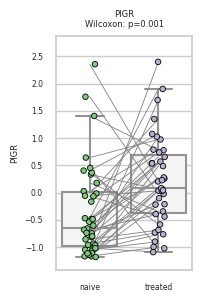

In [68]:

# Only keep those with paired samples
plot_df = dat[dat['patient'].isin(meta['patient'].value_counts()[(meta['patient'].value_counts() == 2)].index)]

gene_name = 'PIGR'

fig, ax = plt.subplots(figsize=(2,3))
sns.boxplot(data=plot_df, x='treatment_status', y=gene_name, color='whitesmoke', fliersize=0, ax=ax)
sns.stripplot(data=plot_df, x='treatment_status', y=gene_name, hue='treatment_status', s=4, edgecolor='black', linewidth=0.6, legend=False, ax=ax)

for patient in plot_df['patient'].unique():
    patient_data = plot_df[plot_df['patient'] == patient]
    ax.plot(patient_data['treatment_status'], patient_data[gene_name], color='gray', linestyle='-', linewidth=0.6)

g1 = plot_df[plot_df['treatment_status'] == 'treated'].sort_values('patient')
g2 = plot_df[plot_df['treatment_status'] == 'naive'].sort_values('patient')

if (pd.Index(g2['patient']) == pd.Index(g2['patient'])).all():
    stat, pval = wilcoxon(g1[gene_name], g2[gene_name])
else:
    stat = np.nan
    pval = np.nan

ax.set_xlabel('')
ax.set_ylim(plot_df[gene_name].min() * 1.2, plot_df[gene_name].max() * 1.2)
ax.set_title(f'{gene_name}\nWilcoxon: p={pval:.3f}')

plt.tight_layout()
plt.show()

### Signature score correlations

In [ ]:
x_var = 'scNMF Club'
x_var = 'BPECT Club Identity'

y_var = 'HALLMARK_PI3K_AKT_MTOR_SIGNALING'
#y_var = 'cGAS_STING_signaling_pathway'
#y_var = 'STING_non_canonical_DNA_DAMAGE'
#y_var = 'PMN-MDSC activity'
#y_var = 'CHD1_signaling_in_NF-κB_pathway'
#y_var = 'MDSC Calcinotto 2018'


sns.set_theme(style='white', palette='Accent',font_scale=0.5)

plot_dfs = [
    dat.copy(),
    dat[dat['treatment_status'] == 'naive'].copy(),
    dat[dat['treatment_status'] == 'treated'].copy(),

]

fig, axs = plt.subplots(1,3,figsize=(12,4.5),sharex=False,sharey=True)

for i,plot_df in enumerate(plot_dfs):
    ax = axs[i]
    xlims = [plot_df[x_var].min() + plot_df[x_var].min()*0.2, plot_df[x_var].max() + plot_df[x_var].max()*0.2]
    ylims = [plot_df[y_var].min() + plot_df[y_var].min()*0.2, plot_df[y_var].max() + plot_df[y_var].max()*0.2]

    # Calculate Spearman correlation
    corr, p_value = spearmanr(plot_df[x_var], plot_df[y_var])

    # Create the scatter plot with regression line

    sns.scatterplot(data=plot_df, x=x_var, y=y_var, hue="treatment_status",edgecolor='black',linewidth=0.5,legend=False,ax=ax)
    sns.regplot(data=plot_df, x=x_var, y=y_var, scatter=False, color='gray',ax=ax)

    # Add correlation and p-value text to the plot
    ax.set_title( f'Spearman Corr: {corr:.2f}\np-value: {p_value:.2e}')

x_var_save = x_var.replace(' ','_')
y_var_save = y_var.replace(' ','_')


plt.tight_layout()
# Show the plot

plt.savefig(plot_save_path + f'DARANA_{x_var_save}_{y_var_save}_correlation_plot_AR_regressed.png',dpi=120)
plt.savefig(plot_save_path + f'DARANA_{x_var_save}_{y_var_save}_correlation_plot_AR_regressed.pdf')
plt.show()


In [ ]:
# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['HALLMARK_ANDROGEN_RESPONSE',
           'BPECT Luminal Identity','BPECT Basal Identity','BPECT Club Identity','BPECT Hillock Identity',
           'CRPC-AR','CRPC-SCL','CRPC-WNT','CRPC-NE',
           'scNMF Club', 'MDSC Hirz 2023', 'MDSC Calcinotto 2018'
           ] 


corr_df_naive = dat.loc[(dat['treatment_status'] == 'naive'),modules].corr()

sns.clustermap(corr_df_naive,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO untreated GSVA score correlation')

plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.png',dpi=120)
plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.pdf')


plt.show()



In [ ]:

# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['Luminal Henry et al. 2018','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

corr_df_treated = dat.loc[(dat['treatment_status'] == 'treated'),modules].corr()

sns.clustermap(corr_df_treated,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO treated GSVA score correlation')

plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.png',dpi=120)
plt.savefig('./plots/DARANA_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.pdf')

plt.show()

## mCRPC bulk data

### Labrecque et al. 2019 cohort

In [ ]:
# Download data and format metadata
dat = pd.read_csv('./data/labrecque_2019/GSE126078_norm_counts_TPM_GRCh38.p13_NCBI.tsv',sep='\t',index_col=0) # NCBI-generated TPM matrix from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE126078

# Replace Entrez IDs with gene symbols
gene_annot = pd.read_csv('./data/labrecque_2019/Human.GRCh38.p13.annot.tsv',sep='\t')
gene_mapping_dict = gene_annot.set_index('GeneID')['Symbol'].to_dict()
dat.index = dat.index.map(gene_mapping_dict)

meta = pd.read_csv('./data/labrecque_2019/GSE126078_series_matrix.txt',sep='\t',skiprows=51,index_col=0)
# Extract relevant columns
meta = meta.T[['!Sample_geo_accession','!Sample_characteristics_ch1','!Sample_source_name_ch1']]

# Drop unused columns
meta = pd.DataFrame(meta.iloc[:,[0,4,5,7]])
column_names = ['GEO_ID','patient','molecular_phenotype','metastatic_site']
meta.columns = column_names

# Map the sample names onto columns
geo_to_sample_dict = meta.reset_index().set_index('GEO_ID')['index'].to_dict()
dat.columns = dat.columns.map(geo_to_sample_dict)

CRPC_only = True #### Adjust accordingly
if CRPC_only:
    meta = meta[meta.index.str.contains('CRPC')]
    dat = dat[meta.index.tolist()]
    meta['molecular_phenotype'] = pd.Categorical([s.split(': ')[1] for s in meta['molecular_phenotype']],categories=['ARpos_NEneg','ARpos_NEpos','ARneg_NEpos','ARlow_NEneg','ARneg_NEneg'])



## TPM normalization
gtf_file = '/lustre/scratch/kiviaho/refdata-gex-GRCh38-2020-A/genes/genes.gtf'


# Extract gene lengths from the GTF file
gene_lengths_mapping_dict = extract_gene_lengths_from_gtf(gtf_file)

# Subset the pseudobulk data to only contain those genes that have annotation
#dat = dat[dat.index.isin(gene_lengths_mapping_dict.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3


# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]

print((meta.index == dat.columns).all())

In [ ]:
# Need to run new scoring after getting rid of the overlap between two genes
gsva_res = gp.gsva(data=tpm,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

modules = ['HALLMARK_ANDROGEN_RESPONSE',
           'BPECT Luminal Identity','BPECT Basal Identity','BPECT Club Identity','BPECT Hillock Identity',
           'CRPC-AR','CRPC-SCL','CRPC-WNT','CRPC-NE',
           'scNMF Club', 'MDSC Hirz 2023', 'MDSC Calcinotto 2018'
           ] 

#'MDSC Hirz 2023','MDSC Calcinotto 2018','PMN-MDSC activity','STING_non_canonical_DNA_DAMAGE','CHD1_signaling_in_NF-κB_pathway',

corr_df = gsva_res_df[modules].astype('float').corr()

sns.set_theme(style='white',font_scale=0.5)

sns.clustermap(corr_df,
               figsize=(4,4),
               cmap='bwr',
               vmin = -1,
               vmax= 1 
               )

plt.title('Labrecque et al. 2019 GSVA score correlation')
#plt.tight_layout()
plt.show()

In [ ]:
gsva_res_meta = pd.merge(meta,gsva_res_df, right_on='Sample Identifier',left_index=True)

sns.set_theme(style=('white'),palette='Dark2',font_scale=0.5)

sig = 'scNMF Club'
var = 'molecular_phenotype'

stat, p_val = kruskal(*gsva_res_meta[[var,sig]].groupby(var)[sig].apply(list))

fig, ax = plt.subplots(figsize=(4,6))
sns.boxplot(data=gsva_res_meta,
            x=var,
            y=sig,
            color='whitesmoke',
            showfliers=False,
            ax=ax)

sns.swarmplot(gsva_res_meta,
              x = var,
              y = sig,
              hue = var,
              edgecolor='black',
              linewidth = 0.5,
              legend = False,
              ax = ax
              )

ax.set_ylim(-0.7,1.0)

plt.savefig(f'./plots/Labracque_et_al_{sig}_GSVA_score_by_{var}.pdf')
plt.show()

for grp1, grp2 in list(combinations(gsva_res_meta[var].cat.categories,2)):
    stat, pval = ranksums(gsva_res_meta[gsva_res_meta[var] == grp1][sig],
                            gsva_res_meta[gsva_res_meta[var] == grp2][sig])

    if pval < 0.001:
        print(f'{grp1} vs {grp2}: {pval:.1e} ***')
    
    elif pval < 0.01:
        print(f'{grp1} vs {grp2}: {pval:.1e} **')
    
    elif pval < 0.05:
        print(f'{grp1} vs {grp2}: {pval:.1e} *')
    
    elif pval >= 0.05:
        print(f'{grp1} vs {grp2}: {pval:.2f}')


In [ ]:

gene_modules_dict = {
    'scNMF Club': gene_set_df['sensescent epithelium'].dropna().tolist() + ['HLA-DRA','CD74','HLA-DRB1','HLA-DPA1','HLA-DQB1','HLA-DMA','CP','LXN','HLA-DPB1','HLA-B','MMP7','C3','HLA-A','HLA-DRB5','SCUBE2','HLA-DQA1','PDZK1IP1','LTF','SOD2','TGM2','PIGR','MGP','TNFAIP2','RARRES3','C1S','C1R','SAA1','CLU','SELENBP1','BIRC3','CXCL2','SLC40A1','FAM3D','SERPING1','HLA-DMB','CFTR','HLA-F','NNMT','IFITM3','SLFN5','CD59'],
    #'CRPC-SCL':gene_set_df['CRPC-SCL'].dropna().tolist(),
    #'CRPC-AR':gene_set_df['CRPC-AR'].dropna().tolist(),
    #'CRPC-NE':gene_set_df['CRPC-NE'].dropna().tolist(),
    #'CRPC-WNT':gene_set_df['CRPC-WNT'].dropna().tolist(),
    #'scNMF senescent epithelium':gene_set_df['sensescent epithelium'].dropna().tolist(),
    #'AR signaling':gene_set_df['AR signaling'].dropna().tolist(),
    #'Tumor region markers': check_top_markers('Tumor')['gene'].tolist(),
    #'Luminal region markers': check_top_markers('Luminal epithelium')['gene'].tolist(),
    #'Basal region markers': check_top_markers('Basal epithelium')['gene'].tolist(),
    #'Club region markers': check_top_markers('Club epithelium')['gene'].tolist(),
    #'Club Henry et al. 2018': ['SCGB3A1','LCN2','PIGR','PSCA','OLFM4','RARRES1','SPINK1','CD74','S100P','WFDC2','FCGBP','GDF15','AGR2','HLA-DRA','PI3','FAM3D','SLPI','C15orf48','TXNIP','DUOXA2','ANKRD36C','CXCL17','TMSB4X','ADGRF1','VSIG2','HLA-DRB1','TFF1','CRABP2','CLDN3','ASS1','RHOV','CEACAM6','B2M','CP','TMEM45B','SRD5A3','PDZK1IP1','AGR3','CEACAM5','BIK','LINC01207','HLA-DRB5','SCCPDH','MMP7','ZG16B','TSPAN3','ELF3','NEAT1','S100A6','AZGP1','PPDPF','MAL2','FOXO3','RAB11FIP1','CYP3A5','FTH1','REEP3','ADIRF','CXCL6','GPRC5A','GLUL','DUSP5','CD24','TMEM165','MGST1','HPGD','CYP1B1','SAA1','GPX2'],
    #'Hillock Henry et al. 2018': ['KRT13','S100P','APOBEC3A','GDF15','CSTB','DUOXA2','OLFM4','GPX2','LYPD3','CXCL17','AKR1C1','SERPINB1','AKR1C2','IGFBP3','IL1RN','MUC4','SDCBP2','HPGD','ADIRF','CLDN4','DHRS9','TRIM31','GPRC5A','EMP1','C15orf48','SNCG','DUSP5','ADGRF1','RAB11FIP1','MGST1','TMSB4X','CLDN3','SDC1','TMPRSS4','MAL2','C9orf16','ASS1','PIM1','DAPP1','PPARG','CLDN7','HEBP2','ELF3','OAS1','AQP3','OAF','CLCA4','CDKN2B','PSCA','PLAUR','S100A9','DDIT4','CCL20','AREG'],
    #'Club-like senescence': ['AGR2','AQP3','CLDN4','CLDN7','CRABP2','CXCL17','ELF3','GPRC5A','IGFBP3','KRT13','KRT16','KRT17','KRT7','LCN2','MAL2','MUC4','PDZK1IP1','PI3','PRSS22','S100A9','S100P','SAA1','SERPINB1','SLPI','TACSTD2','WFDC2'],
    #'IL1A_IL1B_prostate': ['IL1A', 'PTGS2', 'IL1B', 'CXCL3', 'TNFAIP3', 'IER3', 'CCL3', 'NFKBIZ', 'NFKBIA', 'CXCL2', 'SOD2', 'LUCAT1', 'PLEK', 'CCL20', 'KYNU', 'G0S2', 'NAMPT', 'PNRC1', 'PPIF', 'BCL2A1', 'CD93', 'EREG', 'NLRP3', 'THBS1', 'AQP9', 'CD55', 'ACSL1', 'FNDC3B', 'TREM1', 'C5AR1', 'ELL2', 'CD44', 'DUSP6', 'AREG', 'WTAP', 'TNFAIP6', 'B4GALT5', 'GCH1', 'IL1RN', 'MXD1', 'ATP2B1', 'ATP13A3', 'EHD1', 'CXCL1', 'SLC25A37', 'SAMSN1', 'OLR1', 'ZEB2', 'EAF1', 'RNF19B', 'THBD', 'OTUD1', 'CXCL8', 'ANPEP', 'SERPINB2', 'TIMP1', 'CCL4', 'CCL3L1', 'SAV1', 'BTG1', 'S100A8', 'SRGN', 'ICAM1', 'GK', 'FCN1', 'VCAN', 'RASGEF1B', 'MARCKS', 'S100A9', 'SLC11A1', 'NEAT1'],
    #'JAK_STAT_FGFR': ['IRF9','STAT1','STAT2','CCND3','STAT3','IL13RA1','IL11RA1','AKT3','SPRED1','IL10RB','CCND1','PIK3R1','SOCS2','SPRY1','JAK1','PIK3R2','IFNAR1','STAM','STAT5B','PIAS2','AKT2','PTPN11','STAT5A','JUN','CXCL10','CD44','CXCL2','TNF','CD14','TNFRSF1B','BAK1','IRF1','CSF1','FGF1','FGF10','FGF17','FGF18','FGF19','FGF2','FGF20','FGF22','FGF23','FGF3','FGF4','FGF5','FGF6','FGF7','FGF8','FGF9','FGFR1','DUSP6','TGIF','SMAD3','SMAD2','THBS1','FOS','TGFBR2','SOX9','TGFB1','FKBP1A','MMP15','FGFR2','FGFR3'],
    #'JAK_STAT_ACTIVATORS_LIGANDS':["IFNA", "IFNB", "IFNG", "IGF1", "EGF", "PDGF", "CSF1", "KITLG", "FGF1", "FGF2", "FGF10", "FGF9", "BDNF", "VEGF", "HGF", "GH", "TPO", "EPO","PRL", "IL3", "IL5", "IL2", "IL4", "IL6", "LIF", "IL7", "IL9", "IL13","IL15", "IL21", "IL11", "CTF1", "OSM", "CSF3", "LEP", "IL31", "CNTF","IL10", "IL19", "IL20", "IL22", "IL24", "IL26", "IL28A", "IL28B", "IL29","IL12", "IL23", "IL27", "AGT", "F2", "BDK", "PTAF", "CXCL12", "CCL2","CCL5", "CCL15"],
    #'JAK_STAT_ACTIVATORS_RECEPTORS':['IFNAR2','IFNBR2','IFNGR2','IGF1R','EGFR','PDGFR','CSF1R','KIT','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','NTRK2','VEGFR1','VEGFR2','VEGFR4','MET','GHR','TPOR','EPOR','PRLR','IL3RA','IL5RA','IL2RA','IL4RA','IL6RA','IL6ST','LIFR','IL7RA','IL9RA','IL13RA','IL15RA','IL21RA','IL11RA','CTF1R','OSMR','CSF3R','LEPR','IL31RA','CNTFR','IL10RA','IL19RA','IL20RA','IL22RA','IL12RA','IL12RA','IL12RA','IL12RA','IL12RA','IL12RA','IL23RA','IL27RA','AGTR','F2RL1','F2RL2','F2RL3','BDKRB2','PTAFR','CXCR4','CCR2','CCR5','CCR1'],
    #'PDAC T cells': ['LTB','CD2','IL7R','SPOCK2','CCR6','TRAC','ICOS','TRBC1','KLRB1','CD3D','TRBC2','GPR171','CD3E','CCR7','ITK','CD3G','CLEC2D','P2RY10','LCK','BICDL1','GIMAP7','CYTIP','SC5D','LEPROTL1','RCAN3','GNLY','NKG7','CCL5','GZMB','GZMA','KLRD1','PRF1','GZMH','GZMK','CTSW','XCL2','CD8A','GZMM','CST7','CCL4','LINC01871','CD7','CD247','CD96','SH2D2A','SYTL3','APOBEC3G','RUNX3','ARHGAP9','PTPN22'],
    #'NK cells': ['NKG7','GNLY','CD8A'],
    #'PDAC Macrophages': ['APOC1','C1QB','APOE','C1QC','C1QA','SPP1','CCL3L1','CCL3','TREM2','MSR1','GPNMB','MS4A7','SLCO2B1','FCGR3A','FCGR2A','MS4A4A','SLC16A10','CD14','CSF1R','RNASE1','CD68','SDS','VSIG4','MRC1','CYBB'],
    #'PDAC Neutrophils': ['S100A8','CXCL8','FCGR3B','IL1R2','S100A12','PROK2','NAMPT','CSF3R','CMTM2','S100A9','BCL2A1','AC245128.3','ADGRG3','IFITM2','AL034397.3','SAMSN1','IVNS1ABP','AQP9','PTGS2','GCA','BASP1','G0S2','FPR1','PLEK','PHACTR1','FPR2','LITAF','ANP32A','ACSL1','MNDA','RIPOR2','NCF1','ALOX5AP','CPD','SMIM25','TREM1','IRAK3','SRGN','RNF149','NABP1','LST1','NSMAF','LCP1','MME','SLA','SELL','CXCR2','LCP2','HCAR2','C5AR1'],
    #'PDAC Monocytes': ['S100A8','FCN1','S100A9','S100A12','SERPINB2','EREG','CD300E','AC245128.3','APOBEC3A','NLRP3','SLC11A1','AQP9','THBS1','FPR1','MCEMP1','C5AR1','IL1B','SMIM25','ATP2B1-AS1','CSF3R','SLC43A2','CFP','IL1R2','THBD','FPR2'],
    #'PDAC Dendritic cells': ['CEBPB','IL10','NOS2','RORC','S100A8','SOCS1','SOCS3','TGFB1','IL6','CSF2','CSF1','FLT3LG','ARG1','PTGS2','VEGFA','TNF','S100A9','CYBB','NCF1','NCF4','CSF3R','CXCL8','MNDA','LYZ','NCF2','SELL','ICAM1','CD63','CD274','OLR1'],
    #'PDAC T1RS': ['LIPH','SCNN1A','CXCL5','LRG1','MMP7','CEACAM6','PTGS2','C15orf48','TMC5','PRSS22','CFB','LYN','CEACAM5','CXCL6','ZC3H12A','CCL20','EPS8L3','SMOX','SORD','DUOX2','CSF2','CHI3L1','DUOXA2','CXCL3','PIGR','VNN1','ICAM1','C3','TNFAIP2','H6PD','CXCL1','CEACAM7','GK','C9orf16','CEACAM1','CXCL2','NOS2','SFTPD','CSF3','EXOC3L4','LBP','PLA1A','CCL2','LTF','CEBPD','MUC13','NFKBIA','TNIP3','CD14','SLC11A2','PGLYRP1','GK3P','CEACAM8','CEACAM3','PLET1','MICALL2','ERO1A','IL36A','VNN3','CFHR4'],
    'PMN-MDSC activity': ['RPL21','XAF1','CLEC5A','CAMP','CD63','LTF','ANXA3','S100A8','OAS2','ALOX5','IFIT1','CD177','S100A9','CEBPE','LCN2','ANXA1','CTSG','MPO','GSTM1','MEGF9','PYGL','PRTN3','YTHDF3','EMILIN1','ELANE','CHI3L1','LTA4H','VILL','HMGN2','C3','MS4A3','ITGAM','CLEC12A','CST7','HSD11B1','C5AR1','F13A1','ADPGK','HP','IDH1','DHRS7','PGLYRP1','MMP9','ALDH3B1','IGSF6','CYBB','AP3S1','NKG7','RAB31','MSRA','OAS3','SLPI','SYNE1','MECR','PRDX5','MCFD2','RAB3D','PILRA','SCP2','ALAS1','CPNE3','NCF1','MAPKAPK3','ACOT7','CD9','IFITM3','MMP8','PLAC8','NAMPT','ZMPSTE24','ARHGDIB','LGALS1','PADI4','ENO1','DSTN','IFI27L1','MYO1F','ETHE1','CEACAM1','SH3BGRL3','GSN'],
    #'scNMF club_interferon':['HLA-DRA','CD74','HLA-DRB1','HLA-DPA1','HLA-DQB1','HLA-DMA','CP','LXN','HLA-DPB1','HLA-B','MMP7','C3','HLA-A','HLA-DRB5','SCUBE2','HLA-DQA1','PDZK1IP1','LTF','SOD2','TGM2','PIGR','MGP','TNFAIP2','RARRES3','C1S','C1R','SAA1','CLU','SELENBP1','BIRC3','CXCL2','SLC40A1','FAM3D','SERPING1','HLA-DMB','CFTR','HLA-F','NNMT','IFITM3','SLFN5','CD59'],
    #'PMN_MDSC_signature' : ['STAT1','STAT3','STAT6','NFKB1','IRF1','S100A9','S100A8','ANXA1','LYZ2','CXCL1','CXCL2','CXCR1','CXCR2','CXCL8','LILRA3','TREM1','PTGS2','ARG1','ARG2''TGFB1','VEGF','IL6','CSF1','IL1B','WFDC17','IL4R','OLR1','CD84'],
    #'Hirz MDSCs': ['CEBPB','IL10','NOS2','RORC','S100A8','SOCS1','SOCS3','TGFB1','IL6','CSF2','CSF1','FLT3LG','ARG1','PTGS2','VEGFA','TNF','S100A9','CYBB','NCF1','NCF4','CSF3R','CXCL8','MNDA','LYZ','NCF2','SELL','ICAM1','CD63','CD274','OLR1'],
    #'Calcinotto MDSCs': ['CCL15','CCL18','CCL19','CCL20','CCL23','CCL24','CCL27','CCL3','CCL3L3','CCL4','CCL4L2','CXCL10','CXCL12','CXCL13','CXCL16','CXCL6','CXCR1','CXCR2','CXCR3','CXCR4','CXCR5','CXCR6','IFNA1','IFNA10','IFNA13','IFNA14','IFNA16','IFNA17','IFNA2','IFNA21','IFNA4','IFNA5','IFNA6','IFNA7','IFNA8','IFNAR2','IFNB1','IFNG','IL10','IL10RA','IL11RA','IL12A','IL12B','IL12RB1','IL12RB2','IL13','IL17B','IL17F','IL17RA','IL18RAP','IL19','IL1A','IL1B','IL1R2','IL1RAP','IL1RL1','IL1RN','IL21','IL22','IL22RA2','IL23A','IL23R','IL24','IL27','IL2RA','IL2RB','IL2RG','IL4','IL4R','IL5','IL5RA','IL6','IL7','IL7R','IL9','LTA','LTB','LTF','MPO','TGFB2','TNFRSF11B','TNFRSF13C','TNFRSF14','TNFRSF17','TNFRSF18','TNFRSF4','TNFRSF8','TNFSF10','TNFSF11','TNFSF14','TNFSF4','TNFSF8'],
    #'Alshetaiwi MDSCs': ['IFITM3','IFITM2','IFITM1','IL1B','CSTA','SRGN','PROK2','JUNB','DUSP1','SOCS3','BTG1','C19orf12','SELPLG','ASPRV1','IGFBP6','SIRPG','SIRPB1','SIRPA','PLA2G7','CSF3R','CXCR2','TPD52','TSPO','CYP4F3','GRINA','FABP5','CLEC4D','STEAP4','CCR1','LRG1','CLEC4E','CTSD','CD84','GCNT2','ARG2','NPL','FGL2','RNF149','SEPHS2','S100A6','LMNB1','EIF4EBP1','MSRB1','UBB','C5AR1','YPEL3','FCGR2B','FCGR2A','FCGR2C','GSR','TALDO1','ATP6V1G1','S100A11','HP','HPR','ALOX5AP','LITAF','TXN','UPP1','C19orf38','GPCPD1','SNAP23','IL4R','RETNLB','MYD88','ADIPOR1','STK17B','ZYX','RGS3','HDC','ATG3','GDA','SLC40A1','TARM1','CDK2AP2','GLIPR2','TACSTD2','PICALM','MTUS1','FBXL5','SLFN12','SLFN12L','RND1','IER2','MXD1','SIGLEC8','SIGLEC9','SIGLEC7','SIGLEC12','CDKN2D','CD33','SIGLEC6','CD14','SELL','PPT1','SKAP2','SFXN5','ATP11B','OSM','IER3','HBA2','HBA1'],
    #'Lyu SPP1 TAMs': ['APOC1','GPNMB','FTL','CSTB','CTSD','LGALS3','CTSB','LGALS1','PSAP','APOE','ACP5','VIM','CYP27A1','FABP5','ANXA2','CTSL','S100A6','CD68','FTH1','SPP1','VAT1','SMIM25','BRI3','CTSZ','CD9','CD81','APLP2','CD63','S100A10','PLA2G7','LIPA','CAPG','NPL','ATP6V1F','OTOA','TXN','PLD3','ATOX1','SH3BGRL3','CD99','S100A11','TIMP2','CALM3','GM2A','TSPO','NUPR1','PPDPF','BCAP31','MGLL','CYSTM1','NR1H3','NOP10','DBI','IFI30','TSPAN4','LGMN','GPX4','S100A9','LRP1','LMNA','FLNA','MCRIP2','GCHFR','EMP3','LAMP1','CREG1','SDS','RGCC','CD84','P4HB','MGST3','ASAH1','NDUFB9','FBP1','CD44','CTSA','SCD','RAB13','RPS27L','MYDGF','FAM96A','MPP1','ACP2','MIF','ATP6V0B','TREM2','GSTO1','ABCA1','GLUL','PLIN2','POLR2L','HEXB','PLTP','DAB2','PHLDA1','BLVRB','MMP9','ELOB','ITGAX','DMXL2'],
}

signature = 'Canonical_STING_innate_immune_response'
#gene_modules_dict[signature] = gene_modules[signature].dropna().tolist() # Turn on/off as necessary


gene_modules_dict = remove_overlaps(gene_modules_dict)
[print(f'{k}: {len(gene_modules_dict[k])}') for k in list(gene_modules_dict.keys())]

# Need to run new scoring after getting rid of the overlap between two genes
gsva_res = gp.gsva(data=dat,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')


In [ ]:
sns.set_theme(style='white', palette='Dark2',font_scale=0.7)
df = gsva_res_df.copy()
df = pd.merge(df,meta,left_on='Sample Identifier',right_index=True) # Merge

# Set the theme for seaborn
#gene_modules_dict['Hirz MDSCs']
s1 = list(gene_modules_dict.keys())[0]
s2 = list(gene_modules_dict.keys())[1]

print('Score calculated on n genes:')
n1 = len(dat.index.intersection(gene_modules_dict[s1]))
n2 = len(dat.index.intersection(gene_modules_dict[s2]))
print(f'{s1}: {n1}\n{s2}: {n2}')

df[s1] = df[s1].astype('float')
df[s2] = df[s2].astype('float')


# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# First plot
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

sns.scatterplot(
    data=df,
    x=s1,
    y=s2,
    hue='molecular_phenotype',
    s=30,
    linewidth=1,
    edgecolor='black',
    ax=ax
)

sns.regplot(
    data=df,
    x=s1,
    y=s2,
    scatter=False,
    color='black',
    ax=ax
)

stat, p = pearsonr(
    gsva_res_df[s1],
    gsva_res_df[s2]
)

ax.set_title(f'{s1}-{s2} rho={stat:.2f}, p={p:.1e}')
plt.tight_layout()

plt.savefig(f'./figures/Labrecque_RNA_seq_{s1}_{s2}_GSVA_score_scatter.png',dpi=120)
plt.savefig(f'./figures/Labrecque_RNA_seq_{s1}_{s2}_GSVA_score_scatter.pdf')

plt.show()



In [ ]:

df_summary = df[['molecular_phenotype',s1,s2]].groupby('molecular_phenotype').describe()


# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for sample in df_summary.index:
    x_mean = df_summary.loc[sample, (s1, 'mean')]
    x_err = df_summary.loc[sample, (s1, 'std')]

    y_mean = df_summary.loc[sample, (s2, 'mean')]
    y_err = df_summary.loc[sample, (s2, 'std')]
    
    ax.errorbar(x_mean, y_mean,
                xerr=x_err,
                yerr=y_err,
                fmt='o', label=sample)
    
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

ax.set_xlabel(f'{s1} activity score')
ax.set_ylabel(f'{s2} activity score')
ax.legend(title='Samples')
ax.set_title('Mean with standard error')

plt.tight_layout()

plt.savefig(f'./figures/Labrecque_RNA_seq_{s1}_{s2}_GSVA_score_scatter_summarized_by_group.png',dpi=120)
plt.savefig(f'./figures/Labrecque_RNA_seq_{s1}_{s2}_GSVA_score_scatter_summarized_by_group.pdf')

plt.show()

### PELICAN cohort

In [ ]:

# Extract the gene_id to gene_name mapping table from the GTF file
gtf_file = '/lustre/scratch/kiviaho/refdata-gex-GRCh38-2020-A/genes/genes.gtf'


# Create a gene id-gene symbol table
gene_mapping_df = extract_gene_mapping(gtf_file)
gene_mapping_dict = gene_mapping_df.set_index('gene_id').to_dict()['gene_name']
print(gene_mapping_df.head())

# Data downloads

dat = pd.read_csv('../hillock_club_senescence/data/pelican/PELICAN45_rna_featureCounts.txt',sep = '\t',index_col=0,skiprows=1)
dat = dat.drop(columns=['Chr','Start','End','Strand','Length']) # Drop unused
dat.columns = [s.replace('Aligned.sortedByCoord.out.bam','') for s in dat.columns] # Shorten sample names

dat.index = [r.split('.')[0] for r in dat.index] # strip gene version from index

# Replace the index with gene symbols
dat.index = dat.index.map(gene_mapping_dict)
dat = dat[~(dat.index.isna())]
dat = dat[~(dat.sum(axis=1) == 0)]
#dat = dat[~(dat.sum(axis=1) <= dat.shape[1])]
#dat = dat[(dat != 0).sum(axis=1) >= dat.shape[1]/2] # Non-zero counts in 10% of the samples

dat = dat.reset_index().groupby('index').sum() # Summarize duplicated genes


## TPM normalization

# Extract gene lengths from the GTF file
gene_lengths_mapping_dict = extract_gene_lengths_from_gtf(gtf_file)

# Subset the pseudobulk data to only contain those genes that have annotation
#dat = dat[dat.index.isin(gene_lengths_mapping_dict.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths_mapping_dict).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3


# Perform TPM normalization
tpm = calculate_tpm(dat,gene_length_mapping)
tpm = tpm[~(tpm.isna().all(axis=1))]


In [ ]:
# Need to run new scoring after getting rid of the overlap between two genes
gsva_res = gp.gsva(data=tpm,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

modules = ['HALLMARK_ANDROGEN_RESPONSE','Luminal Henry et al. 2018','Lung KACs Han et al. 2024','AR signaling','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

#'MDSC Hirz 2023','MDSC Calcinotto 2018','PMN-MDSC activity','STING_non_canonical_DNA_DAMAGE','CHD1_signaling_in_NF-κB_pathway',

corr_df = gsva_res_df[modules].astype('float').corr()

sns.clustermap(corr_df,
               figsize=(4,4),
               cmap='bwr')

plt.title('PELICAN cohort GSVA score correlation')
#plt.tight_layout()
plt.show()

In [ ]:

gene_modules_dict = {
    'scNMF Club': gene_set_df['sensescent epithelium'].dropna().tolist() + ['HLA-DRA','CD74','HLA-DRB1','HLA-DPA1','HLA-DQB1','HLA-DMA','CP','LXN','HLA-DPB1','HLA-B','MMP7','C3','HLA-A','HLA-DRB5','SCUBE2','HLA-DQA1','PDZK1IP1','LTF','SOD2','TGM2','PIGR','MGP','TNFAIP2','RARRES3','C1S','C1R','SAA1','CLU','SELENBP1','BIRC3','CXCL2','SLC40A1','FAM3D','SERPING1','HLA-DMB','CFTR','HLA-F','NNMT','IFITM3','SLFN5','CD59'],
    #'CRPC-AR':gene_set_df['CRPC-AR'].dropna().tolist(),
    #'CRPC-NE':gene_set_df['CRPC-NE'].dropna().tolist(),
    #'CRPC-WNT':gene_set_df['CRPC-WNT'].dropna().tolist(),
    #'CRPC-SCL':gene_set_df['CRPC-SCL'].dropna().tolist(),
    #'scNMF senescent epithelium':gene_set_df['sensescent epithelium'].dropna().tolist(),
    #'AR signaling':gene_set_df['AR signaling'].dropna().tolist(),
    #'Tumor region markers': check_top_markers('Tumor')['gene'].tolist(),
    #'Luminal region markers': check_top_markers('Luminal epithelium')['gene'].tolist(),
    #'Basal region markers': check_top_markers('Basal epithelium')['gene'].tolist(),
    #'Club region markers': check_top_markers('Club epithelium')['gene'].tolist(),
    #'Club Henry et al. 2018': ['SCGB3A1','LCN2','PIGR','PSCA','OLFM4','RARRES1','SPINK1','CD74','S100P','WFDC2','FCGBP','GDF15','AGR2','HLA-DRA','PI3','FAM3D','SLPI','C15orf48','TXNIP','DUOXA2','ANKRD36C','CXCL17','TMSB4X','ADGRF1','VSIG2','HLA-DRB1','TFF1','CRABP2','CLDN3','ASS1','RHOV','CEACAM6','B2M','CP','TMEM45B','SRD5A3','PDZK1IP1','AGR3','CEACAM5','BIK','LINC01207','HLA-DRB5','SCCPDH','MMP7','ZG16B','TSPAN3','ELF3','NEAT1','S100A6','AZGP1','PPDPF','MAL2','FOXO3','RAB11FIP1','CYP3A5','FTH1','REEP3','ADIRF','CXCL6','GPRC5A','GLUL','DUSP5','CD24','TMEM165','MGST1','HPGD','CYP1B1','SAA1','GPX2'],
    #'Hillock Henry et al. 2018': ['KRT13','S100P','APOBEC3A','GDF15','CSTB','DUOXA2','OLFM4','GPX2','LYPD3','CXCL17','AKR1C1','SERPINB1','AKR1C2','IGFBP3','IL1RN','MUC4','SDCBP2','HPGD','ADIRF','CLDN4','DHRS9','TRIM31','GPRC5A','EMP1','C15orf48','SNCG','DUSP5','ADGRF1','RAB11FIP1','MGST1','TMSB4X','CLDN3','SDC1','TMPRSS4','MAL2','C9orf16','ASS1','PIM1','DAPP1','PPARG','CLDN7','HEBP2','ELF3','OAS1','AQP3','OAF','CLCA4','CDKN2B','PSCA','PLAUR','S100A9','DDIT4','CCL20','AREG'],
    #'Club-like senescence': ['AGR2','AQP3','CLDN4','CLDN7','CRABP2','CXCL17','ELF3','GPRC5A','IGFBP3','KRT13','KRT16','KRT17','KRT7','LCN2','MAL2','MUC4','PDZK1IP1','PI3','PRSS22','S100A9','S100P','SAA1','SERPINB1','SLPI','TACSTD2','WFDC2'],
    #'IL1A_IL1B_prostate': ['IL1A', 'PTGS2', 'IL1B', 'CXCL3', 'TNFAIP3', 'IER3', 'CCL3', 'NFKBIZ', 'NFKBIA', 'CXCL2', 'SOD2', 'LUCAT1', 'PLEK', 'CCL20', 'KYNU', 'G0S2', 'NAMPT', 'PNRC1', 'PPIF', 'BCL2A1', 'CD93', 'EREG', 'NLRP3', 'THBS1', 'AQP9', 'CD55', 'ACSL1', 'FNDC3B', 'TREM1', 'C5AR1', 'ELL2', 'CD44', 'DUSP6', 'AREG', 'WTAP', 'TNFAIP6', 'B4GALT5', 'GCH1', 'IL1RN', 'MXD1', 'ATP2B1', 'ATP13A3', 'EHD1', 'CXCL1', 'SLC25A37', 'SAMSN1', 'OLR1', 'ZEB2', 'EAF1', 'RNF19B', 'THBD', 'OTUD1', 'CXCL8', 'ANPEP', 'SERPINB2', 'TIMP1', 'CCL4', 'CCL3L1', 'SAV1', 'BTG1', 'S100A8', 'SRGN', 'ICAM1', 'GK', 'FCN1', 'VCAN', 'RASGEF1B', 'MARCKS', 'S100A9', 'SLC11A1', 'NEAT1'],
    #'JAK_STAT_FGFR': ['IRF9','STAT1','STAT2','CCND3','STAT3','IL13RA1','IL11RA1','AKT3','SPRED1','IL10RB','CCND1','PIK3R1','SOCS2','SPRY1','JAK1','PIK3R2','IFNAR1','STAM','STAT5B','PIAS2','AKT2','PTPN11','STAT5A','JUN','CXCL10','CD44','CXCL2','TNF','CD14','TNFRSF1B','BAK1','IRF1','CSF1','FGF1','FGF10','FGF17','FGF18','FGF19','FGF2','FGF20','FGF22','FGF23','FGF3','FGF4','FGF5','FGF6','FGF7','FGF8','FGF9','FGFR1','DUSP6','TGIF','SMAD3','SMAD2','THBS1','FOS','TGFBR2','SOX9','TGFB1','FKBP1A','MMP15','FGFR2','FGFR3'],
    #'JAK_STAT_ACTIVATORS_LIGANDS':["IFNA", "IFNB", "IFNG", "IGF1", "EGF", "PDGF", "CSF1", "KITLG", "FGF1", "FGF2", "FGF10", "FGF9", "BDNF", "VEGF", "HGF", "GH", "TPO", "EPO","PRL", "IL3", "IL5", "IL2", "IL4", "IL6", "LIF", "IL7", "IL9", "IL13","IL15", "IL21", "IL11", "CTF1", "OSM", "CSF3", "LEP", "IL31", "CNTF","IL10", "IL19", "IL20", "IL22", "IL24", "IL26", "IL28A", "IL28B", "IL29","IL12", "IL23", "IL27", "AGT", "F2", "BDK", "PTAF", "CXCL12", "CCL2","CCL5", "CCL15"],
    #'JAK_STAT_ACTIVATORS_RECEPTORS':['IFNAR2','IFNBR2','IFNGR2','IGF1R','EGFR','PDGFR','CSF1R','KIT','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','NTRK2','VEGFR1','VEGFR2','VEGFR4','MET','GHR','TPOR','EPOR','PRLR','IL3RA','IL5RA','IL2RA','IL4RA','IL6RA','IL6ST','LIFR','IL7RA','IL9RA','IL13RA','IL15RA','IL21RA','IL11RA','CTF1R','OSMR','CSF3R','LEPR','IL31RA','CNTFR','IL10RA','IL19RA','IL20RA','IL22RA','IL12RA','IL12RA','IL12RA','IL12RA','IL12RA','IL12RA','IL23RA','IL27RA','AGTR','F2RL1','F2RL2','F2RL3','BDKRB2','PTAFR','CXCR4','CCR2','CCR5','CCR1'],
    #'PDAC T cells': ['LTB','CD2','IL7R','SPOCK2','CCR6','TRAC','ICOS','TRBC1','KLRB1','CD3D','TRBC2','GPR171','CD3E','CCR7','ITK','CD3G','CLEC2D','P2RY10','LCK','BICDL1','GIMAP7','CYTIP','SC5D','LEPROTL1','RCAN3','GNLY','NKG7','CCL5','GZMB','GZMA','KLRD1','PRF1','GZMH','GZMK','CTSW','XCL2','CD8A','GZMM','CST7','CCL4','LINC01871','CD7','CD247','CD96','SH2D2A','SYTL3','APOBEC3G','RUNX3','ARHGAP9','PTPN22'],
    #'NK cells': ['NKG7','GNLY','CD8A'],
    #'PDAC Macrophages': ['APOC1','C1QB','APOE','C1QC','C1QA','SPP1','CCL3L1','CCL3','TREM2','MSR1','GPNMB','MS4A7','SLCO2B1','FCGR3A','FCGR2A','MS4A4A','SLC16A10','CD14','CSF1R','RNASE1','CD68','SDS','VSIG4','MRC1','CYBB'],
    #'PDAC Neutrophils': ['S100A8','CXCL8','FCGR3B','IL1R2','S100A12','PROK2','NAMPT','CSF3R','CMTM2','S100A9','BCL2A1','AC245128.3','ADGRG3','IFITM2','AL034397.3','SAMSN1','IVNS1ABP','AQP9','PTGS2','GCA','BASP1','G0S2','FPR1','PLEK','PHACTR1','FPR2','LITAF','ANP32A','ACSL1','MNDA','RIPOR2','NCF1','ALOX5AP','CPD','SMIM25','TREM1','IRAK3','SRGN','RNF149','NABP1','LST1','NSMAF','LCP1','MME','SLA','SELL','CXCR2','LCP2','HCAR2','C5AR1'],
    #'PDAC Monocytes': ['S100A8','FCN1','S100A9','S100A12','SERPINB2','EREG','CD300E','AC245128.3','APOBEC3A','NLRP3','SLC11A1','AQP9','THBS1','FPR1','MCEMP1','C5AR1','IL1B','SMIM25','ATP2B1-AS1','CSF3R','SLC43A2','CFP','IL1R2','THBD','FPR2'],
    #'PDAC Dendritic cells': ['CEBPB','IL10','NOS2','RORC','S100A8','SOCS1','SOCS3','TGFB1','IL6','CSF2','CSF1','FLT3LG','ARG1','PTGS2','VEGFA','TNF','S100A9','CYBB','NCF1','NCF4','CSF3R','CXCL8','MNDA','LYZ','NCF2','SELL','ICAM1','CD63','CD274','OLR1'],
    #'PDAC T1RS': ['LIPH','SCNN1A','CXCL5','LRG1','MMP7','CEACAM6','PTGS2','C15orf48','TMC5','PRSS22','CFB','LYN','CEACAM5','CXCL6','ZC3H12A','CCL20','EPS8L3','SMOX','SORD','DUOX2','CSF2','CHI3L1','DUOXA2','CXCL3','PIGR','VNN1','ICAM1','C3','TNFAIP2','H6PD','CXCL1','CEACAM7','GK','C9orf16','CEACAM1','CXCL2','NOS2','SFTPD','CSF3','EXOC3L4','LBP','PLA1A','CCL2','LTF','CEBPD','MUC13','NFKBIA','TNIP3','CD14','SLC11A2','PGLYRP1','GK3P','CEACAM8','CEACAM3','PLET1','MICALL2','ERO1A','IL36A','VNN3','CFHR4'],
    'PMN-MDSC activity': ['RPL21','XAF1','CLEC5A','CAMP','CD63','LTF','ANXA3','S100A8','OAS2','ALOX5','IFIT1','CD177','S100A9','CEBPE','LCN2','ANXA1','CTSG','MPO','GSTM1','MEGF9','PYGL','PRTN3','YTHDF3','EMILIN1','ELANE','CHI3L1','LTA4H','VILL','HMGN2','C3','MS4A3','ITGAM','CLEC12A','CST7','HSD11B1','C5AR1','F13A1','ADPGK','HP','IDH1','DHRS7','PGLYRP1','MMP9','ALDH3B1','IGSF6','CYBB','AP3S1','NKG7','RAB31','MSRA','OAS3','SLPI','SYNE1','MECR','PRDX5','MCFD2','RAB3D','PILRA','SCP2','ALAS1','CPNE3','NCF1','MAPKAPK3','ACOT7','CD9','IFITM3','MMP8','PLAC8','NAMPT','ZMPSTE24','ARHGDIB','LGALS1','PADI4','ENO1','DSTN','IFI27L1','MYO1F','ETHE1','CEACAM1','SH3BGRL3','GSN'],
    #'scNMF club_interferon':['HLA-DRA','CD74','HLA-DRB1','HLA-DPA1','HLA-DQB1','HLA-DMA','CP','LXN','HLA-DPB1','HLA-B','MMP7','C3','HLA-A','HLA-DRB5','SCUBE2','HLA-DQA1','PDZK1IP1','LTF','SOD2','TGM2','PIGR','MGP','TNFAIP2','RARRES3','C1S','C1R','SAA1','CLU','SELENBP1','BIRC3','CXCL2','SLC40A1','FAM3D','SERPING1','HLA-DMB','CFTR','HLA-F','NNMT','IFITM3','SLFN5','CD59'],
    #'PMN_MDSC_signature' : ['STAT1','STAT3','STAT6','NFKB1','IRF1','S100A9','S100A8','ANXA1','LYZ2','CXCL1','CXCL2','CXCR1','CXCR2','CXCL8','LILRA3','TREM1','PTGS2','ARG1','ARG2''TGFB1','VEGF','IL6','CSF1','IL1B','WFDC17','IL4R','OLR1','CD84'],
    #'Hirz MDSCs': ['CEBPB','IL10','NOS2','RORC','S100A8','SOCS1','SOCS3','TGFB1','IL6','CSF2','CSF1','FLT3LG','ARG1','PTGS2','VEGFA','TNF','S100A9','CYBB','NCF1','NCF4','CSF3R','CXCL8','MNDA','LYZ','NCF2','SELL','ICAM1','CD63','CD274','OLR1'],
    #'Calcinotto MDSCs': ['CCL15','CCL18','CCL19','CCL20','CCL23','CCL24','CCL27','CCL3','CCL3L3','CCL4','CCL4L2','CXCL10','CXCL12','CXCL13','CXCL16','CXCL6','CXCR1','CXCR2','CXCR3','CXCR4','CXCR5','CXCR6','IFNA1','IFNA10','IFNA13','IFNA14','IFNA16','IFNA17','IFNA2','IFNA21','IFNA4','IFNA5','IFNA6','IFNA7','IFNA8','IFNAR2','IFNB1','IFNG','IL10','IL10RA','IL11RA','IL12A','IL12B','IL12RB1','IL12RB2','IL13','IL17B','IL17F','IL17RA','IL18RAP','IL19','IL1A','IL1B','IL1R2','IL1RAP','IL1RL1','IL1RN','IL21','IL22','IL22RA2','IL23A','IL23R','IL24','IL27','IL2RA','IL2RB','IL2RG','IL4','IL4R','IL5','IL5RA','IL6','IL7','IL7R','IL9','LTA','LTB','LTF','MPO','TGFB2','TNFRSF11B','TNFRSF13C','TNFRSF14','TNFRSF17','TNFRSF18','TNFRSF4','TNFRSF8','TNFSF10','TNFSF11','TNFSF14','TNFSF4','TNFSF8'],
    #'Alshetaiwi MDSCs': ['IFITM3','IFITM2','IFITM1','IL1B','CSTA','SRGN','PROK2','JUNB','DUSP1','SOCS3','BTG1','C19orf12','SELPLG','ASPRV1','IGFBP6','SIRPG','SIRPB1','SIRPA','PLA2G7','CSF3R','CXCR2','TPD52','TSPO','CYP4F3','GRINA','FABP5','CLEC4D','STEAP4','CCR1','LRG1','CLEC4E','CTSD','CD84','GCNT2','ARG2','NPL','FGL2','RNF149','SEPHS2','S100A6','LMNB1','EIF4EBP1','MSRB1','UBB','C5AR1','YPEL3','FCGR2B','FCGR2A','FCGR2C','GSR','TALDO1','ATP6V1G1','S100A11','HP','HPR','ALOX5AP','LITAF','TXN','UPP1','C19orf38','GPCPD1','SNAP23','IL4R','RETNLB','MYD88','ADIPOR1','STK17B','ZYX','RGS3','HDC','ATG3','GDA','SLC40A1','TARM1','CDK2AP2','GLIPR2','TACSTD2','PICALM','MTUS1','FBXL5','SLFN12','SLFN12L','RND1','IER2','MXD1','SIGLEC8','SIGLEC9','SIGLEC7','SIGLEC12','CDKN2D','CD33','SIGLEC6','CD14','SELL','PPT1','SKAP2','SFXN5','ATP11B','OSM','IER3','HBA2','HBA1'],
    #'Lyu SPP1 TAMs': ['APOC1','GPNMB','FTL','CSTB','CTSD','LGALS3','CTSB','LGALS1','PSAP','APOE','ACP5','VIM','CYP27A1','FABP5','ANXA2','CTSL','S100A6','CD68','FTH1','SPP1','VAT1','SMIM25','BRI3','CTSZ','CD9','CD81','APLP2','CD63','S100A10','PLA2G7','LIPA','CAPG','NPL','ATP6V1F','OTOA','TXN','PLD3','ATOX1','SH3BGRL3','CD99','S100A11','TIMP2','CALM3','GM2A','TSPO','NUPR1','PPDPF','BCAP31','MGLL','CYSTM1','NR1H3','NOP10','DBI','IFI30','TSPAN4','LGMN','GPX4','S100A9','LRP1','LMNA','FLNA','MCRIP2','GCHFR','EMP3','LAMP1','CREG1','SDS','RGCC','CD84','P4HB','MGST3','ASAH1','NDUFB9','FBP1','CD44','CTSA','SCD','RAB13','RPS27L','MYDGF','FAM96A','MPP1','ACP2','MIF','ATP6V0B','TREM2','GSTO1','ABCA1','GLUL','PLIN2','POLR2L','HEXB','PLTP','DAB2','PHLDA1','BLVRB','MMP9','ELOB','ITGAX','DMXL2'],
}

signature = 'Regulators_extracellular_cGAMP'
#gene_modules_dict[signature] = gene_modules[signature].dropna().tolist() # Turn on/off as necessary


#### REMOVE THE OVERLAPS BETWEEN GENE SIGNARTURES TO ENSURE AN UNBIASED CORRELATION ANALYSIS ####
gene_modules_dict = remove_overlaps(gene_modules_dict)
print('')
[print(f'{k}: {len(gene_modules_dict[k])}') for k in list(gene_modules_dict.keys())]

all_genes = combined_list = [item for sublist in gene_modules_dict.values() for item in sublist]


In [ ]:
# Need to run new scoring after getting rid of the overlap between two genes
gsva_res = gp.gsva(data=tpm_normalized_dat,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')


sns.set_theme(style='white', palette=sns.color_palette([sns.color_palette('Set2')[1]]),font_scale=0.7)
df = gsva_res_df.copy()

# Set the theme for seaborn
#gene_modules_dict['Hirz MDSCs']
s1 = list(gene_modules_dict.keys())[0]
s2 = list(gene_modules_dict.keys())[1]

df[s1] = df[s1].astype('float')
df[s2] = df[s2].astype('float')

print('Score calculated on n genes:')
n1 = len(tpm_normalized_dat.index.intersection(gene_modules_dict[s1]))
n2 = len(tpm_normalized_dat.index.intersection(gene_modules_dict[s2]))
print(f'{s1}: {n1}\n{s2}: {n2}')


# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# First plot
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

sns.scatterplot(
    data=df,
    x=s1,
    y=s2,
#    hue='sample',
    s=30,
    linewidth=1,
    edgecolor='black',
    ax=ax
)

sns.regplot(
    data=df,
    x=s1,
    y=s2,
    scatter=False,
    color='black',
    ax=ax
)

stat, p = pearsonr(
    gsva_res_df[s1],
    gsva_res_df[s2]
)

ax.set_title(f'{s1}-{s2} rho={stat:.2f}, p={p:.1e}')
plt.tight_layout()

plt.savefig(f'./figures/PELICAN_RNA_seq_{s1}_{s2}_GSVA_score_scatter.png',dpi=120)
plt.savefig(f'./figures/PELICAN_RNA_seq_{s1}_{s2}_GSVA_score_scatter.pdf')

plt.show()



## ARNEO gene set scores and group comparisons

In [ ]:
""" 
# This was apparently array data – according to Ebrahim at least

#array_data = pd.read_csv('/lustre/scratch/kiviaho/',index_col=0)
#metadata = pd.read_csv('/lustre/scratch/kiviaho/club_scrnaseq/arneo_rnaseq_metadata.csv',index_col=0)

# Create a treatment-naive vs neoadjuvant-treated divide
metadata['TRT_GROUP_SIMPLE'] = pd.Categorical(metadata['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])

# Match the ordering
array_data = array_data[metadata.index.intersection(array_data.columns)]

# Create a treatment-naive vs neoadjuvant-treated divide
metadata['TRT_GROUP_SIMPLE'] = pd.Categorical(metadata['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])
# Match the ordering
array_data = array_data[metadata.index.intersection(array_data.columns)]

# Score genes
gsva_res = gp.gsva(data=array_data,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

gsva_res_df = gsva_res_df.set_index('Sample Identifier').astype('float')

# Regressing out androgen response
gsva_res_df = regress_out_signature(gsva_res_df, 'HALLMARK_ANDROGEN_RESPONSE') # HALLMARK_ANDROGEN_RESPONSE, AR signaling general
#gsva_res_df = regress_out_signatures(gsva_res_df, ['HALLMARK_ANDROGEN_RESPONSE','Fibroblast region','Muscle region']) # HALLMARK_ANDROGEN_RESPONSE, AR signaling

metadata = metadata.loc[gsva_res_df.index]

if (gsva_res_df.index == metadata.index).all():
    dat = pd.concat([gsva_res_df,metadata], axis=1)

dat['TRT_GROUP'] = pd.Categorical(dat['TRT_GROUP'],categories=['treatment-naive','adt','adt_apa'])
dat['TRT_GROUP_SIMPLE'] = pd.Categorical(dat['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])
dat.loc[:,gene_modules_dict.keys()] = dat.loc[:,gsva_res_df.columns].astype('float')
 """

In [2]:

# Using the real set of RNA-seq data

rnaseq_data = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo-rnaseq/TR169-arneo-tpm-star-rsem.csv',index_col=0)
metadata = pd.read_csv('/lustre/scratch/kiviaho/hillock_club_senescence/data/arneo-rnaseq/case-metadata.txt',index_col=0,sep='\t')

rnaseq_data = rnaseq_data.drop(columns=['ensembl_gene_id','entrezgene_id']).set_index('hgnc_symbol')

missing_meta = pd.DataFrame({
    'TRT_GROUP':np.repeat('treatment-naive',len(rnaseq_data.columns.difference(metadata.index))),
    'tc': np.nan,
    'tc_method': np.nan,
    }, index = rnaseq_data.columns.difference(metadata.index)
    )

metadata = pd.concat([metadata,missing_meta])

# Create a treatment-naive vs neoadjuvant-treated divide
metadata['TRT_GROUP_SIMPLE'] = pd.Categorical(metadata['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])
metadata['tc'] = metadata['tc'].astype('float')

# Subset to treatment-naive
#metadata = metadata[metadata['TRT_GROUP'] == 'treatment-naive']

# Match the ordering
rnaseq_data = rnaseq_data[metadata.index.intersection(rnaseq_data.columns)]
metadata = metadata.loc[rnaseq_data.columns.intersection(metadata.index)]

""" 
# Calculate GSVA enrichment
gsva_res_df = gsva_res_df.loc[metadata.index.intersection(gsva_res_df.index)]
gsva_res = gp.gsva(data=rnaseq_data,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=100000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')
gsva_res_df = gsva_res_df.set_index('Sample Identifier').astype('float')

if (gsva_res_df.index == metadata.index).all():
    dat = pd.concat([gsva_res_df,metadata], axis=1)

# Regressing out androgen response
gsva_res_df = regress_out_signature(gsva_res_df, 'HALLMARK_ANDROGEN_RESPONSE') # HALLMARK_ANDROGEN_RESPONSE, AR signaling general
gsva_res_df = regress_out_signatures(gsva_res_df, ['HALLMARK_ANDROGEN_RESPONSE','Fibroblast region','Muscle region']) # HALLMARK_ANDROGEN_RESPONSE, AR signaling
    
 """

rnaseq_data_zscore = zscore(rnaseq_data,axis=1)

# Calculate median Z-score of the set of genes
median_zscore = pd.DataFrame(columns = gene_modules_dict.keys(),index = rnaseq_data_zscore.columns)
for k in gene_modules_dict:
    sig = rnaseq_data_zscore.index.intersection(gene_modules_dict[k])
    median_zscore[k] = rnaseq_data_zscore.loc[sig].median()

# Regress out the effect of andorgen signaling
median_zscore = regress_out_signatures(median_zscore, ['HALLMARK_ANDROGEN_RESPONSE','BPECT Luminal Identity'])

if (median_zscore.index == metadata.index).all():
    dat = pd.concat([median_zscore,metadata], axis=1)

dat = pd.concat([dat,rnaseq_data_zscore.T],axis=1)

dat['TRT_GROUP'] = pd.Categorical(dat['TRT_GROUP'],categories=['treatment-naive','adt','adt_apa']).remove_unused_categories()
dat['TRT_GROUP_SIMPLE'] = pd.Categorical(dat['TRT_GROUP'].map({'treatment-naive':'treatment-naive','adt':'neoadjuvant-treated','adt_apa':'neoadjuvant-treated'}),categories=['treatment-naive','neoadjuvant-treated'])




### Install and run pySNAIL: https://github.com/kuijjerlab/PySNAIL

In [ ]:
# Endpoint goal is to look at the correlation between the BPECT gene Identities --> Does treatment have an effect on their coexpression?
# Is there a mixing of the phenotypes? How does it work? Any implications?

### Split samples according to PTEN expression (Only if untreated)

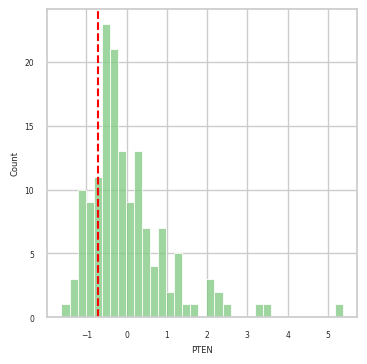

In [76]:
gene = 'PTEN'
fig,ax = plt.subplots(figsize=(4,4))

# Quantiles computed from TCGA
#q1 = dat[gene].quantile((43 + 50) / 333)
q1 = dat[gene].quantile(0.2)

ax.axvline(x=q1, linestyle='--',color='red')
sns.histplot(dat,
             x = gene,
             binwidth=0.2,
             ax = ax
             
             )

plt.show()

dat[gene+'_putative_CNA'] = 'wt'
dat.loc[dat[gene] <= q1, gene+'_putative_CNA'] = 'loss'

dat[gene+'_putative_CNA'] = pd.Categorical(dat[gene+'_putative_CNA'],categories=['wt','loss'])


In [ ]:

gene_set = 'BPECT Club Identity'
var = gene+'_putative_CNA'

# Create the plot
fig, ax = plt.subplots(figsize=(3,4))

sns.boxplot(data=dat,
            x=var,
            y=gene_set,
            color='whitesmoke',
            showfliers=False,
            ax=ax)

sns.stripplot(data=dat,
            x=var,
            y=gene_set,
            hue=var,
            ax=ax,
            edgecolor='black',
            linewidth=1,
            legend=False)

# Add p-value to the title
title = 'Independent samples t-test:'

for g1, g2 in list(combinations(dat[var].cat.categories,2)):
    stat, pval = ttest_ind(dat[dat[var] == g1][gene_set],
            dat[dat[var] == g2][gene_set])
    title = title + '\n' + f'{g1} vs {g2}: p-value: {pval:.1e}'

plt.title(title)
plt.tight_layout()
plt.show()

### Score correlations with regards to treatment

/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/infercnvpy/lib/python3.8/site-packages/seaborn/re

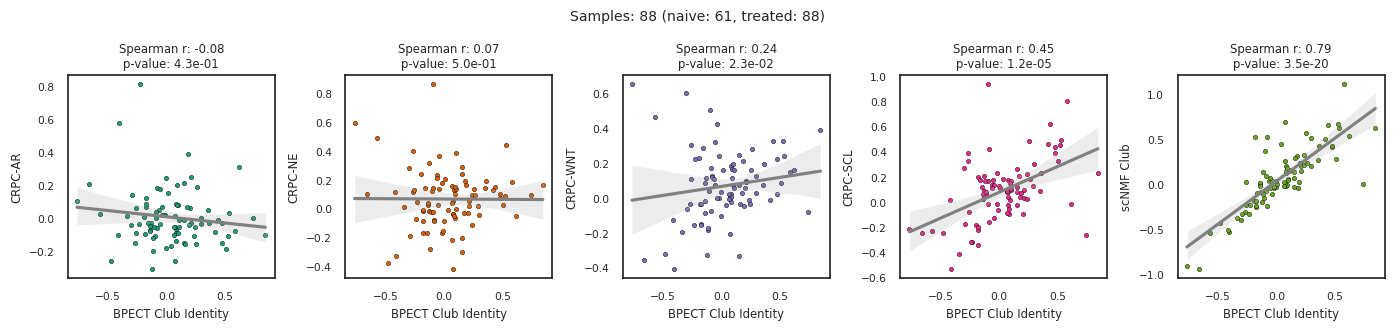

In [77]:
sns.set_theme(style='white',font_scale=0.7)

pal = sns.color_palette('Dark2')
correlation_var = 'BPECT Club Identity'

df = dat.copy()
#df = df[df['TRT_GROUP_SIMPLE'] == 'treatment-naive'] # Just the treated samples
df = df[df['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'] # Just the treated samples
df = df[~df[correlation_var].isna()]
signatures = ['CRPC-AR','CRPC-NE','CRPC-WNT','CRPC-SCL','scNMF Club']
fig, axs = plt.subplots(1,5,figsize=(14,3.3))
for i,sig in enumerate(signatures):
    
    ax = axs[i]
    stat, pval = spearmanr(df[sig],df[correlation_var])
    sns.scatterplot(df,
                    x = correlation_var,
                    y= sig,
                    edgecolor='black',
                    linewidth=0.3,
                    c=pal[i],
                    s = 10,
                    ax=ax
                    )
    sns.regplot(df,
                    x = correlation_var,
                    y= sig,
                    scatter=False,
                    color='gray',
                    ax=ax
                    )
    

    ax.set_title(f'Spearman r: {stat:.2f}\np-value: {pval:.1e}')

n_naive = len(dat[dat['TRT_GROUP_SIMPLE'] == 'treatment-naive'])
n_treated = len(dat[dat['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'])

plt.suptitle(f'Samples: {len(df)} (naive: {n_naive}, treated: {n_treated})')
plt.tight_layout()


#plt.savefig('plots/ARNEO_rnaseq_CRPC_subtype_gsva_score_vs_pcf_select_tc.png',dpi=120)
#plt.savefig(f'plots/ARNEO_rnaseq_CRPC_subtype_gsva_score_vs_{correlation_var}_treated.png',dpi=120)
#plt.savefig(f'plots/ARNEO_rnaseq_CRPC_subtype_gsva_score_vs_{correlation_var}_naive.png',dpi=120)

plt.show()

### Plot the treatment-induced score change

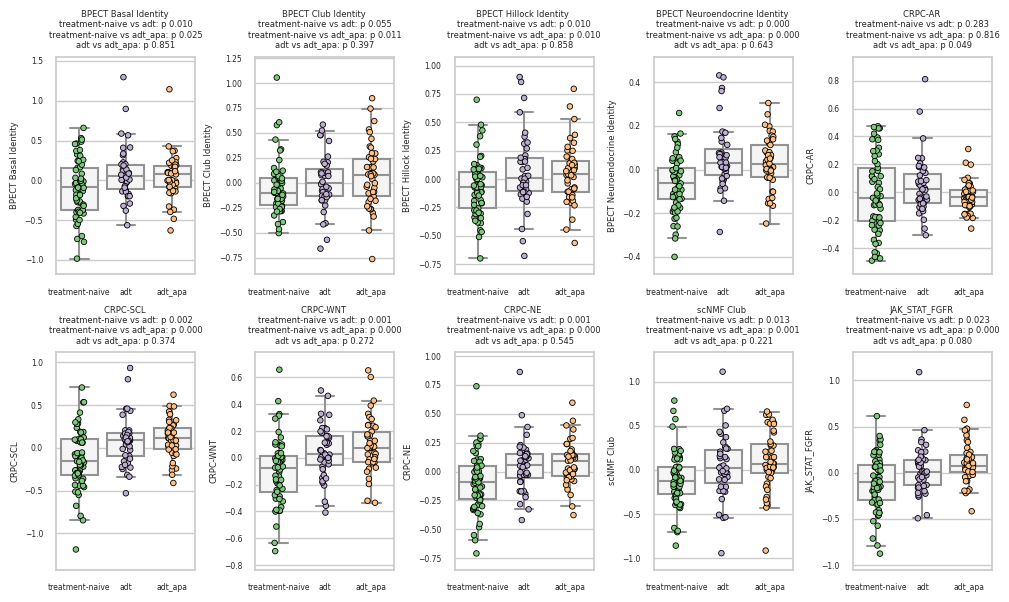

In [44]:
# USE MEDIAN ZSCORE REGRESSED FOR HALLMARK_ANDROGEN_RESPONSE & BPECT LUMINAL IDENTITY

# Simple
sns.set_theme(style='whitegrid',font_scale=0.5,palette='Accent')

modules = [
    'BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', 'BPECT Neuroendocrine Identity',
    'CRPC-AR', 'CRPC-SCL', 'CRPC-WNT', 'CRPC-NE', 'scNMF Club', 'JAK_STAT_FGFR'
]

cat = 'TRT_GROUP'#'TRT_GROUP_SIMPLE'

# Calculate the number of columns needed
num_modules = len(modules)
num_cols = 5
num_rows = int(np.ceil(num_modules / num_cols))  # 5 columns

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*2,num_rows * 3))

for idx, signature in enumerate(modules):
    row = idx // num_cols
    col = idx % num_cols

    ax = axs[row, col]

    sns.boxplot(data=dat, x=cat, y=signature,color='whitesmoke',fliersize=0, ax = ax)

    sns.stripplot(dat,
                x = cat,
                y = signature,
                hue = cat,
                #color='gray',
                s = 4,
                edgecolor='black',
                linewidth = 0.6,
                legend=False,
                ax = ax
                )

    g1 = dat[dat[cat] == 'treatment-naive']
    g2 = dat[dat[cat] == 'neoadjuvant-treated']

    # Add p-value to the title
    title = ''

    for g1, g2 in list(combinations(dat[cat].cat.categories,2)):
        stat, pval = ranksums(dat[dat[cat] == g1][signature],
                dat[dat[cat] == g2][signature])
        title = title + '\n' + f'{g1} vs {g2}: p {pval:.3f}'

    ax.set_xlabel('')
    ax.set_ylim(dat[signature].min() * 1.2, dat[signature].max() * 1.2)
    ax.set_title(f'{signature} {title}')

plt.tight_layout()
plt.show()


### Single gene

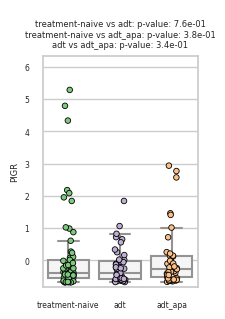

In [55]:
# USE MEDIAN ZSCORE REGRESSED FOR HALLMARK_ANDROGEN_RESPONSE & BPECT LUMINAL IDENTITY

# Simple
sns.set_theme(style='whitegrid',font_scale=0.5,palette='Accent')

gene_name = 'PIGR'
cat = 'TRT_GROUP'

plt.figure(figsize=(2,3))

sns.boxplot(data=dat, x=cat, y=gene_name,color='whitesmoke',fliersize=0)

sns.stripplot(dat,
            x = cat,
            y = gene_name,
            hue = cat,
            #color='gray',
            s = 4,
            edgecolor='black',
            linewidth = 0.6,
            legend=False
            )

g1 = dat[dat[cat] == 'treatment-naive']
g2 = dat[dat[cat] == 'neoadjuvant-treated']

# Add p-value to the title
title = gene_name

for g1, g2 in list(combinations(dat[cat].cat.categories,2)):
    stat, pval = ranksums(dat[dat[cat] == g1][gene_name],
            dat[dat[cat] == g2][gene_name])
    title = title + '\n' + f'{g1} vs {g2}: p-value: {pval:.1e}'

plt.xlabel('')

plt.ylim(dat[gene_name].min()*1.2,dat[gene_name].max()*1.2)
plt.title(title)

plt.show()


### Gene score correlation plot

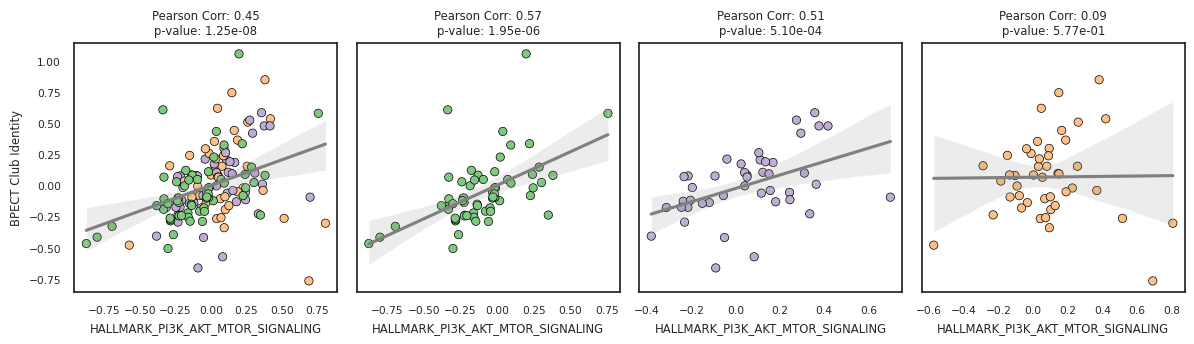

In [9]:
y_var = 'BPECT Club Identity'
x_var = 'HALLMARK_PI3K_AKT_MTOR_SIGNALING'

sns.set_theme(style='white', palette='Accent',font_scale=0.7)
plot_df = dat[dat['TRT_GROUP'] == 'treatment-naive'].copy() # treatment-naive, adt, adt_apa


plot_dfs = [
    dat.copy(),
    dat[dat['TRT_GROUP'] == 'treatment-naive'].copy(),
    dat[dat['TRT_GROUP'] == 'adt'].copy(),
    dat[dat['TRT_GROUP'] == 'adt_apa'].copy()

]

fig, axs = plt.subplots(1,4,figsize=(12,3.5),sharex=False,sharey=True)

for i,plot_df in enumerate(plot_dfs):
    ax = axs[i]
    xlims = [plot_df[x_var].min() + plot_df[x_var].min()*0.2, plot_df[x_var].max() + plot_df[x_var].max()*0.2]
    ylims = [plot_df[y_var].min() + plot_df[y_var].min()*0.2, plot_df[y_var].max() + plot_df[y_var].max()*0.2]

    # Calculate Spearman correlation
    corr, p_value = spearmanr(plot_df[x_var], plot_df[y_var])

    # Create the scatter plot with regression line

    sns.scatterplot(data=plot_df, x=x_var, y=y_var, hue="TRT_GROUP",edgecolor='black',linewidth=0.5,legend=False,ax=ax)
    sns.regplot(data=plot_df, x=x_var, y=y_var, scatter=False, color='gray',ax=ax)

    # Add correlation and p-value text to the plot
    ax.set_title( f'Pearson Corr: {corr:.2f}\np-value: {p_value:.2e}')



x_var_save = x_var.replace(' ','_')
y_var_save = y_var.replace(' ','_')


plt.tight_layout()
# Show the plot

#plt.savefig(plot_save_path + f'ARNEO_{x_var_save}_{y_var_save}_correlation_plot.png',dpi=120)
#plt.savefig(plot_save_path + f'ARNEO_{x_var_save}_{y_var_save}_correlation_plot.pdf')
plt.show()


In [ ]:
# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['Luminal Henry et al. 2018','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

corr_df_naive = dat.loc[(dat['TRT_GROUP_SIMPLE'] == 'treatment-naive'),modules].corr()

sns.clustermap(corr_df_naive,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO untreated GSVA score correlation')

plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.png',dpi=120)
plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_naive.pdf')


plt.show()

In [ ]:
# Gene signature scores post ANDROGEN RESPONSE FILTERING
modules = ['Luminal Henry et al. 2018','Lung KACs Han et al. 2024','PDAC T1RS Caronni et al. 2023','scNMF Club','JAK_STAT_FGFR','Club Henry et al. 2018','Hillock Henry et al. 2018','CRPC-AR','CRPC-WNT','CRPC-SCL','CRPC-NE','PCCAT Scissor_CRPC_Enza_Epi UP','PCCAT Scissor_CRPC_Enza_Epi DOWN'] # gene_modules_dict.keys()

corr_df_treated = dat.loc[(dat['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'),modules].corr()

sns.clustermap(corr_df_treated,
               figsize=(4,4),
               cmap='bwr',
               vmax = 1,
               vmin = -1)

plt.title('ARNEO treated GSVA score correlation')

plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.png',dpi=120)
plt.savefig('./plots/ARNEO_HALLMARK_ANDROGEN_SIGNALING_regressed_out_epithelial_correlation_treated.pdf')

plt.show()

### Check which samples has ATAC-seq data

In [ ]:
arneo_atac = pd.read_csv('./ARNEO_ATAC_seq_deviation_scores.txt',sep='\t')
gsva_res_atac = gsva_res_df.loc[gsva_res_df['Sample Identifier'].isin(arneo_atac.columns),['Sample Identifier','scNMF Club','CRPC-SCL','TRT_GROUP']]

gsva_res_atac = gsva_res_atac.sort_values('CRPC-SCL',ascending=False).reset_index(drop=True)
gsva_res_atac['CRPC-SCL score rank'] = np.arange(len(gsva_res_atac)) + 1 

gsva_res_atac = gsva_res_atac.sort_values('scNMF Club',ascending=False).reset_index(drop=True)
gsva_res_atac['scNMF Club score rank'] = np.arange(len(gsva_res_atac)) + 1 


gsva_res_atac

In [ ]:
gsva_res_atac.to_excel('./ARNEO_RNA_seq_scores_for_ATAC_seq_samples.xlsx',index=False)

In [ ]:
plot_df = df.copy()
plot_df = plot_df[plot_df['Sample Identifier'].isin(gsva_res_atac['Sample Identifier'].tolist())]


sns.set_theme(style='white',palette='Accent')

# Define the params for drawing significance bars
textprops = [
    {'ymaxm':1.15, 'xmin':0.2,'xmax':0.45,'textx':0.5,'textym':1.17},
    {'ymaxm':1.45, 'xmin':0.2,'xmax':0.8,'textx':1,'textym':1.47},
    {'ymaxm':1.25, 'xmin':0.55,'xmax':0.8,'textx':1.5,'textym':1.27},
]

score_name = 'CRPC-SCL'

min_value = plot_df[score_name].min()
max_value = plot_df[score_name].max()

# Create the axes
fig, axs = plt.subplots(1,2,figsize=(6,4),sharey=False,gridspec_kw={'width_ratios':[3,2]})

ax = axs[0]

# Plot the box + swarplot on the first axis
sns.boxplot(data=plot_df, x='TRT_GROUP', y=score_name,color='whitesmoke',ax=ax,fliersize=0)
sns.swarmplot(data=plot_df, x='TRT_GROUP', y=score_name,hue='TRT_GROUP',ax=ax,legend=None)

# Get the unique categories in 'TRT_GROUP'
categories = plot_df['TRT_GROUP'].cat.categories

# Perform pairwise Wilcoxon rank-sum tests
it=0
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        cat1 = categories[i]
        cat2 = categories[j]
        
        # Get the data for each category
        data1 = plot_df[plot_df['TRT_GROUP'] == cat1][score_name]
        data2 = plot_df[plot_df['TRT_GROUP'] == cat2][score_name]
        
        # Perform Wilcoxon rank-sum test
        statistic, p_value = ranksums(data1, data2)
        asterisks = ''
        if p_value < 0.001:
            asterisks = '***'
        elif p_value < 0.01:
            asterisks = '**'
        elif p_value < 0.05:
            asterisks = '*'

        if p_value < 0.05:
            props_dict = textprops[it]
            ax.axhline(y = max_value*props_dict['ymaxm'], xmin=props_dict['xmin'],xmax=props_dict['xmax'],c='black')
            ax.text(s=asterisks,x=props_dict['textx'],y=max_value*props_dict['textym'],ha='center',fontdict={'fontsize':12})
        it += 1
        
ax.set_ylim(min_value*1.2,max_value*1.7)

# Create a kernel density plot on the second ax object
ax = axs[1]
sns.kdeplot(
data=plot_df, y=score_name, hue='TRT_GROUP',
fill=True, common_norm=False,
alpha=.5, linewidth=0, legend=None,
ax=ax
)
ax.set_ylim(min_value*1.2,max_value*1.7)

# Strip all but the plot from this axis
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.suptitle(score_name + ' GSVA score split by treatment')
plt.tight_layout()

s = score_name.replace(' ','_').replace('/','_')
plt.savefig(plot_save_path + f'{s}_gsva_score_split_by_treatment_atac_samples.pdf')
plt.savefig(plot_save_path + f'{s}_gsva_score_split_by_treatment_atac_samples.png',dpi=120) 
plt.show()

In [ ]:
treated_gsva_res = gsva_res_atac[gsva_res_atac['TRT_GROUP'].isin(['adt','adt_apa'])]
qntiles = treated_gsva_res['scNMF Club'].describe()

treated_gsva_res[treated_gsva_res['scNMF Club'] <= qntiles['25%']]

In [ ]:
treated_gsva_res[treated_gsva_res['scNMF Club'] >= qntiles['75%']]

### Examine gene modules overlap and DEGs of single genes

In [ ]:
signatures = ['JAK_STAT_FGFR','scNMF Club'] # JAK_STAT_FGFR, JAK_STAT_ACTIVATORS, scNMF senescent epithelium, 'Club Henry et al. 2018','scNMF club_interferon', PMN-MDSC activity, PMN_MDSC_signature

# Ensure all genes are present in the index
fishers_df = pd.DataFrame(index = pd.Index(set(rnaseq_data.index.tolist()  + all_genes )))
for sig_name in signatures:

    sig = gene_modules_dict[sig_name]
    sig = [g for g in sig if g in fishers_df.index.tolist()]

    #preface
    fishers_df[sig_name] = 'no'
    fishers_df.loc[sig,sig_name] = 'yes'

    fishers_df[sig_name] = pd.Categorical(fishers_df[sig_name],categories=['yes','no'])

fishers_df = pd.crosstab(fishers_df[signatures[0]],fishers_df[signatures[1]])
overlap = set(gene_modules_dict[signatures[0]]).intersection(set(gene_modules_dict[signatures[1]]))

#fishers_df.iloc[0,0] +=1
print(overlap)
oddsratio, pval = fisher_exact(fishers_df)

print(fishers_df)
print(f'OR: {oddsratio:.2f}, p-value: {pval:.2e}')

### Plot a 3-way venn diagram with club region markers & Henry et al. signatures

## Differential gene expression analysis

In [ ]:
from statsmodels.stats.multitest import multipletests

def run_differential_expression_test(df1,df2):

    # Create a results_df
    result = pd.DataFrame(index=df1.index, columns=['avg_lfc','stat','p_value'],dtype=np.float64)
    result['avg_lfc'] = df1.mean(axis=1) - df2.mean(axis=1)

    for g in tqdm(df1.index,unit='gene'):
        stat,pval = ranksums(df1.loc[g],df2.loc[g])
        result.loc[g,'stat'] = stat
        result.loc[g,'p_value'] = pval

    # Perform BH correction
    result['adj_pval'] = multipletests(result['p_value'], method='fdr_bh')[1]

    return(result)

In [ ]:
# Load the data

# Define sample categories
trt_naive = rnaseq_data[metadata[metadata['TRT_GROUP'] == 'treatment-naive'].index]
adt_treated = rnaseq_data[metadata[metadata['TRT_GROUP'] == 'adt'].index]
adt_apa_treated = rnaseq_data[metadata[metadata['TRT_GROUP'] == 'adt_apa'].index]
neadt_treated_all = rnaseq_data[metadata[metadata['TRT_GROUP_SIMPLE'] == 'neoadjuvant-treated'].index]

# Run differential expression testing between the sample categories
deg_adt_res = run_differential_expression_test(adt_treated,trt_naive)
deg_adt_apa_res = run_differential_expression_test(adt_apa_treated,trt_naive)
deg_treated_untreated = run_differential_expression_test(neadt_treated_all,trt_naive)

In [ ]:
save_excel = False

# Get the upregulated genes
adt_upreg = deg_adt_res[(deg_adt_res['avg_lfc']>= 1) & (deg_adt_res['adj_pval'] < 0.05)].index.tolist()
adt_apa_upreg = deg_adt_apa_res[(deg_adt_apa_res['avg_lfc']>= 1) & (deg_adt_apa_res['adj_pval'] < 0.05)].index.tolist()

arneo_degs_df = pd.DataFrame.from_dict({'adt':adt_upreg,'adt_apa':adt_apa_upreg},orient='index').T

if save_excel:
    # Create a Pandas Excel writer using XlsxWriter as the engine
    with pd.ExcelWriter('arneo_deg_results.xlsx', engine='xlsxwriter') as writer:
        # Write each dataframe to a different worksheet
        deg_adt_res.to_excel(writer, sheet_name='degarelix', index=True)
        deg_adt_apa_res.to_excel(writer, sheet_name='degarelix+apalutamide', index=True)
    writer.save()

# Format the data for easy access
deg_adt_res['treatment_grp'] = 'adt'
deg_adt_apa_res['treatment_grp'] = 'adt_apa'

deg_res = pd.concat([deg_adt_res[['avg_lfc','adj_pval','treatment_grp']],
           deg_adt_apa_res[['avg_lfc','adj_pval','treatment_grp']]
])

### Volcano plot treatment-naïve vs neoadjuvant-treated

In [ ]:
sns.set_theme(style='white', palette=sns.color_palette(['lightgray','firebrick']),font_scale=0.5)

col_name = 'scNMF Club'
plot_df = deg_treated_untreated
lfc_thr = 0.5

#plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]

plot_df['annotation'] = 'anone'
plot_df.loc[set(gene_modules_dict[col_name]).intersection(set(plot_df.index)),'annotation'] = 'gene_set'

plot_df['-log10_adj_pval'] = -np.log10(plot_df['adj_pval'])
plot_df = plot_df.sort_values('annotation')

fig, ax = plt.subplots(figsize=(4,3))

sns.scatterplot(data=plot_df,
                x='avg_lfc',
                y='-log10_adj_pval',
                linewidth=0.1,
                edgecolor='black',
                s=10,
                hue='annotation',
                legend=False,
                ax=ax)

ax.set_xlim(-4, 4)
ax.set_ylim(-0.5, plot_df['-log10_adj_pval'].max() + 1)
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
ax.axvline(x=-lfc_thr, color='black', linestyle='--')
ax.axvline(x=lfc_thr, color='black', linestyle='--')

ax.set_title(f'DE results for genes in {col_name}')

annot_genes = ['ELF3','KLF5','SOX9','PIGR','LTF','MMP7']
# Adding gene name labels
for i in range(len(plot_df)):
    if (np.abs(plot_df['avg_lfc'].iloc[i]) >= lfc_thr and plot_df['adj_pval'].iloc[i] < 0.05) & (plot_df.index[i] in gene_modules_dict[col_name]):
        if plot_df.index[i] in annot_genes:
            ax.text(plot_df['avg_lfc'].iloc[i], 
                    plot_df['-log10_adj_pval'].iloc[i], 
                    plot_df.index[i], 
                    fontsize=6, 
                    ha='left')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

gene_set = col_name.replace(' ','_')
plt.savefig(plot_save_path + f'{gene_set}_degs_volcano_plot_treat_naive_vs_neoadjuvant_treated.pdf')

plt.show()


In [ ]:
plot_df[plot_df['annotation'] == 'gene_set'].sort_values('avg_lfc',ascending=False)[:30]

In [ ]:
gene_modules_dict['Upregulated'] = plot_df[(plot_df['adj_pval'] < 0.05) & (plot_df['avg_lfc'] >= 0.5)].index.tolist()
gene_modules_dict['Downregulated'] = plot_df[(plot_df['adj_pval'] < 0.05) & (plot_df['avg_lfc'] <= -0.5)].index.tolist()

In [ ]:
signatures = ['Downregulated','scNMF Club'] # JAK_STAT_FGFR, JAK_STAT_ACTIVATORS, scNMF senescent epithelium, 'Club Henry et al. 2018','scNMF club_interferon', PMN-MDSC activity, PMN_MDSC_signature

# Ensure all genes are present in the index
fishers_df = pd.DataFrame(index = pd.Index(set(rnaseq_data.index.tolist()  + all_genes )))
for sig_name in signatures:
    if sig_name in gene_modules_dict:
        sig  = gene_modules_dict[sig_name]
    else:
        print('Signature name not found')
    sig = [g for g in sig if g in fishers_df.index.tolist()]

    #preface
    fishers_df[sig_name] = 'no'
    fishers_df.loc[sig,sig_name] = 'yes'

    fishers_df[sig_name] = pd.Categorical(fishers_df[sig_name],categories=['yes','no'])

fishers_df = pd.crosstab(fishers_df[signatures[0]],fishers_df[signatures[1]])
overlap = set(gene_modules_dict[signatures[0]]).intersection(set(gene_modules_dict[signatures[1]]))

#fishers_df.iloc[0,0] +=1
print(overlap)
oddsratio, pval = fisher_exact(fishers_df)

print(fishers_df)
print(f'OR: {oddsratio:.2f}, p-value: {pval:.2e}')

### Volcano plots ADT / ADT-APA specified

In [ ]:
sns.set_theme(style='white', palette='Accent',font_scale=0.5)

col_name = 'scNMF Club'
plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]
lfc_thr = 0.5

plot_df['-log10_adj_pval'] = -np.log10(plot_df['adj_pval'])
plot_df['treatment_grp'] = pd.Categorical(plot_df['treatment_grp'], categories=['treatment-naive', 'adt', 'adt_apa'])

fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=plot_df,
                x='avg_lfc',
                y='-log10_adj_pval',
                #s=10,
                linewidth=0.5,
                edgecolor='black',
                hue='treatment_grp',
                legend=False,
                ax=ax)

ax.set_xlim(-1.5, 2.5)
ax.set_ylim(-0.5, plot_df['-log10_adj_pval'].max() + 1)
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
ax.axvline(x=-lfc_thr, color='black', linestyle='--')
ax.axvline(x=lfc_thr, color='black', linestyle='--')

ax.set_title(f'DE results for genes in {col_name}')


annot_genes = ['ELF3','KLF5','SOX9','KRT13','IGFBP3','CRABP2','TACSTD2','PSCA']
if len(gene_modules_dict[col_name]) < 140:
    # Adding gene name labels
    for i in range(len(plot_df)):
        #if np.abs(plot_df['avg_lfc'].iloc[i]) >= lfc_thr and plot_df['adj_pval'].iloc[i] < 0.05:
        if plot_df.index[i] in annot_genes:
            ax.text(plot_df['avg_lfc'].iloc[i], 
                    plot_df['-log10_adj_pval'].iloc[i], 
                    plot_df.index[i], 
                    fontsize=6, 
                    ha='left')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

gene_set = col_name.replace(' ','_')
plt.savefig(plot_save_path + f'{gene_set}_degs_volcano_plot.pdf')

plt.show()


In [ ]:
plot_df.sort_values('avg_lfc',ascending=False)[:30]

In [ ]:
gene_modules_dict['Upregulated'] = deg_res[(deg_res['adj_pval'] < 0.05) & (deg_res['avg_lfc'] >= 0.5)].index.unique().tolist()
gene_modules_dict['Downregulated'] = deg_res[(deg_res['adj_pval'] < 0.05) & (deg_res['avg_lfc'] <= -0.5)].index.unique().tolist()

In [ ]:
signatures = ['Upregulated','scNMF Club'] # JAK_STAT_FGFR, JAK_STAT_ACTIVATORS, scNMF senescent epithelium, 'Club Henry et al. 2018','scNMF club_interferon', PMN-MDSC activity, PMN_MDSC_signature

# Ensure all genes are present in the index
fishers_df = pd.DataFrame(index = pd.Index(set(rnaseq_data.index.tolist()  + all_genes )))
for sig_name in signatures:
    if sig_name in gene_modules_dict:
        sig  = gene_modules_dict[sig_name]
    else:
        print('Signature name not found')
    sig = [g for g in sig if g in fishers_df.index.tolist()]

    #preface
    fishers_df[sig_name] = 'no'
    fishers_df.loc[sig,sig_name] = 'yes'

    fishers_df[sig_name] = pd.Categorical(fishers_df[sig_name],categories=['yes','no'])

fishers_df = pd.crosstab(fishers_df[signatures[0]],fishers_df[signatures[1]])
overlap = set(gene_modules_dict[signatures[0]]).intersection(set(gene_modules_dict[signatures[1]]))

#fishers_df.iloc[0,0] +=1
print(overlap)
oddsratio, pval = fisher_exact(fishers_df)

print(fishers_df)
print(f'OR: {oddsratio:.2f}, p-value: {pval:.2e}')

In [ ]:
sns.set_theme(style='white', palette='Accent')

for col_name in gene_modules_dict.keys():
    
    plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]

    plot_df['-log10_adj_pval'] = -np.log10(plot_df['adj_pval'])
    plot_df['treatment_grp'] = pd.Categorical(plot_df['treatment_grp'], categories=['treatment-naive', 'adt', 'adt_apa'])

    fig, ax = plt.subplots(figsize=(6,5))
    sns.scatterplot(data=plot_df,
                    x='avg_lfc',
                    y='-log10_adj_pval',
                    s=50,
                    hue='treatment_grp',
                    legend=False,
                    ax=ax)

    ax.set_xlim(-4, 4)
    ax.set_ylim(-0.5, plot_df['-log10_adj_pval'].max() + 1)
    ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
    ax.axvline(x=-1, color='black', linestyle='--')
    ax.axvline(x=1, color='black', linestyle='--')

    ax.set_title(f'DE results for genes in {col_name}')

    if len(gene_modules_dict[col_name]) < 100:
        # Adding gene name labels
        for i in range(len(plot_df)):
            if np.abs(plot_df['avg_lfc'].iloc[i]) >= 1 and plot_df['adj_pval'].iloc[i] < 0.05:
                ax.text(plot_df['avg_lfc'].iloc[i], 
                        plot_df['-log10_adj_pval'].iloc[i], 
                        plot_df.index[i], 
                        fontsize=10, 
                        ha='left')

    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    
    gene_set = col_name.replace(' ','_')
#    plt.savefig(plot_save_path + f'{gene_set}_degs_volcano_plot.pdf')

    plt.show()


In [ ]:
# Genes that are DEGs in both treatments
col_name = 'scNMF senescent epithelium'
plot_df = deg_res.loc[set(gene_modules_dict[col_name]).intersection(deg_res.index)]

df = plot_df[(plot_df['avg_lfc'] >= 1) & (plot_df['adj_pval'] < 0.05)]
df = df.reset_index().groupby('index').mean().sort_values('avg_lfc')
df